<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/Computational_Interferometry_with_Wigner_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [21]:
# @title 0) Environment & versions
!pip -q install pylint tqdm

import sys, platform, numpy as np, matplotlib, matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 250
plt.rcParams['figure.facecolor'] = 'white'

print("Python:", sys.version)
print("Platform:", platform.platform())
print("NumPy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.6.97+-x86_64-with-glibc2.35
NumPy: 2.0.2
Matplotlib: 3.10.0


In [22]:
# @title 1) Write the toolkit module to disk
module_code = r'''
"""
wigner_qc_tools.py
A compact toolkit for computational interferometry + quantum-computation analogies.

Core functions:
- wigner_wvd: Discrete Wigner–Ville distribution (DT WVD) for 1D arrays.
- cross_wigner_wvd: Cross-Wigner (two-signal) variant.
- gaussian_1d, make_double_slit: Signal builders.
- far_field_fft: Fraunhofer/far-field via FFT.
- normalize_wavefunction: L2 normalization on a sampled grid.
- wigner_negativity_kenfack: Kenfack–Życzkowski style negativity (scale-invariant).
- mzi_unitary / hadamard / rz: MZI = H · Rz(φ) · H (up to a global phase).

Open-access anchors you can cite in a caption:
- Wigner marginals: O’Connell (2010), arXiv:1009.4431.
- Double-slit Wigner pictures: Pietersoone et al. (2024), arXiv:2403.05684; Dragoman (2004), arXiv:quant-ph/0402168.
- Cross-Wigner & interference: Marinho et al. (2023/2024), arXiv:2401.00083.
- MZI ≡ H·Rz·H, and interferometer-as-algorithm: Cleve et al. (1999), arXiv:quant-ph/9903061; Shadbolt et al. (2012), arXiv:1108.3309.
- Wigner negativity as a resource: Kenfack & Życzkowski (2004), arXiv:quant-ph/0406015; Veitch et al. (2012), arXiv:1201.1256.
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import Tuple
import numpy as np
from numpy.typing import ArrayLike


# ---------------------- Basic utilities ----------------------

def normalize_wavefunction(psi: ArrayLike) -> np.ndarray:
    """L2-normalize a discrete 1D complex array psi so that sum |psi|^2 = 1."""
    psi = np.asarray(psi, dtype=np.complex128)
    norm2 = np.sum(np.abs(psi) ** 2).real
    if norm2 == 0.0:
        return psi.copy()
    return psi / np.sqrt(norm2)


def gaussian_1d(x: np.ndarray, x0: float, sigma: float) -> np.ndarray:
    """Unit-area Gaussian over x (useful for controlled comparisons)."""
    g = np.exp(-0.5 * ((x - x0) / sigma) ** 2)
    area = np.trapz(g, x)
    if area != 0:
        g = g / area
    return g


def make_double_slit(x: np.ndarray, separation: float, width: float, phase_diff: float = 0.0) -> np.ndarray:
    """Two narrow Gaussians as slits with optional relative phase."""
    slit1 = gaussian_1d(x, -separation / 2.0, width)
    slit2 = gaussian_1d(x,  separation / 2.0, width) * np.exp(1j * phase_diff)
    return slit1 + slit2


def far_field_fft(psi: np.ndarray) -> np.ndarray:
    """Far-field (Fraunhofer) pattern up to overall constants; complex FFT amplitudes."""
    return np.fft.fftshift(np.fft.fft(np.fft.ifftshift(psi)))


# ---------------------- Discrete Wigner–Ville ----------------------

def wigner_wvd(psi: ArrayLike) -> Tuple[np.ndarray, np.ndarray]:
    """Discrete Wigner–Ville distribution (DT WVD).

    WVD[n,k] = Σ_m psi[n+m] psi*[n-m] e^{-i 2π k m / N}, using bounded lags.
    Returns:
        omega: angular-frequency grid in [-π, π) (shape N)
        W: real-valued Wigner–Ville density with shape (N_freq, N_time)
    """
    psi = np.asarray(psi, dtype=np.complex128)
    N = psi.size
    W = np.zeros((N, N), dtype=np.complex128)
    half = N // 2
    for n in range(N):
        kernel = np.zeros(N, dtype=np.complex128)
        m_vals = np.arange(-half, half, dtype=int)
        for idx, m in enumerate(m_vals):
            n1 = n + m
            n2 = n - m
            if (0 <= n1 < N) and (0 <= n2 < N):
                kernel[idx] = psi[n1] * np.conj(psi[n2])
        spec = np.fft.fft(np.fft.ifftshift(kernel))
        W[:, n] = spec
    omega = np.fft.fftshift(2.0 * np.pi * np.fft.fftfreq(N, d=1.0))
    W = np.fft.fftshift(W, axes=0)
    return omega, np.real(W)


def cross_wigner_wvd(psi1: ArrayLike, psi2: ArrayLike) -> Tuple[np.ndarray, np.ndarray]:
    """Cross-Wigner distribution W(psi1, psi2)."""
    psi1 = np.asarray(psi1, dtype=np.complex128)
    psi2 = np.asarray(psi2, dtype=np.complex128)
    assert psi1.shape == psi2.shape
    N = psi1.size
    W = np.zeros((N, N), dtype=np.complex128)
    half = N // 2
    for n in range(N):
        kernel = np.zeros(N, dtype=np.complex128)
        m_vals = np.arange(-half, half, dtype=int)
        for idx, m in enumerate(m_vals):
            n1 = n + m
            n2 = n - m
            if (0 <= n1 < N) and (0 <= n2 < N):
                kernel[idx] = psi1[n1] * np.conj(psi2[n2])
        spec = np.fft.fft(np.fft.ifftshift(kernel))
        W[:, n] = spec
    omega = np.fft.fftshift(2.0 * np.pi * np.fft.fftfreq(N, d=1.0))
    W = np.fft.fftshift(W, axes=0)
    return omega, W  # complex (phase encodes relative phase)


def wigner_negativity_kenfack(W: np.ndarray) -> float:
    """Kenfack–Życzkowski-style negativity δ = (||W||_1 - ∥W∥_1 under positivity)/2.
    We use a scale-invariant discrete proxy:
      Let P = sum(W>0), N = -sum(W<0). Scale s = 1/(P - N) ⇒ sum(sW)=1. Then δ = s*N.
    """
    Wr = np.real(W)
    pos = np.sum(Wr[Wr > 0.0])
    neg = -np.sum(Wr[Wr < 0.0])
    denom = pos - neg
    if denom == 0.0:
        return 0.0
    scale = 1.0 / denom
    return float(scale * neg)


# ---------------------- MZI and single-qubit SU(2) ----------------------

def hadamard() -> np.ndarray:
    return (1.0 / np.sqrt(2.0)) * np.array([[1.0, 1.0], [1.0, -1.0]], dtype=np.complex128)

def rz(phi: float) -> np.ndarray:
    return np.array([[np.exp(-1j * phi / 2.0), 0.0], [0.0, np.exp(1j * phi / 2.0)]], dtype=np.complex128)

def beamsplitter_5050() -> np.ndarray:
    """Symmetric 50:50 beam splitter (a standard convention; global phases ignored)."""
    return hadamard()

def phase_shifter(phi: float) -> np.ndarray:
    """Phase shifter acting on the upper mode (|1⟩-phase)."""
    return np.array([[1.0, 0.0], [0.0, np.exp(1j * phi)]], dtype=np.complex128)

def mzi_unitary(phi: float) -> np.ndarray:
    """Mach–Zehnder: U = BS · P(φ) · BS  ≡  H · Rz(φ) · H  (up to a global phase)."""
    return beamsplitter_5050() @ phase_shifter(phi) @ beamsplitter_5050()


# ---------------------- Config dataclasses ----------------------

@dataclass
class Grid1D:
    N: int = 256
    xmin: float = -10.0
    xmax: float = 10.0
    def coords(self) -> np.ndarray:
        return np.linspace(self.xmin, self.xmax, self.N)

@dataclass
class TwoGaussianParams:
    sigma: float = 0.6
    separation: float = 4.0
    phase_difference: float = np.pi / 2.0  # radians

@dataclass
class DoubleSlitParams:
    width: float = 0.4
    separation: float = 5.0
    phase_difference: float = 0.0  # classic case


# ---------------------- Plotting helpers (single-axes figures) ----------------------

def _new_fig(title: str = ""):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(7, 4))
    fig.set_facecolor("white")
    if title:
        ax.set_title(title, pad=12.0)
    return fig, ax

def plot_signal_and_intensity(x: np.ndarray, psi: np.ndarray, title: str):
    import matplotlib.pyplot as plt
    fig, ax = _new_fig(title)
    ax.plot(x, np.real(psi), label="Re[ψ(x)]")
    ax.plot(x, np.imag(psi), label="Im[ψ(x)]", linestyle="--")
    ax.plot(x, np.abs(psi) ** 2, label="|ψ(x)|$^2$", linewidth=2.0)
    ax.set_xlabel("Position x (arb. units)")
    ax.set_ylabel("Amplitude / Intensity (arb.)")
    ax.grid(alpha=0.3)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    plt.tight_layout()
    return fig, ax

def plot_wigner(omega: np.ndarray, x: np.ndarray, W: np.ndarray, title: str, xlabel: str, ylabel: str):
    import matplotlib.pyplot as plt
    fig, ax = _new_fig(title)
    extent = [x[0], x[-1], float(omega[0]), float(omega[-1])]
    im = ax.imshow(np.real(W), origin="lower", aspect="auto", extent=extent, interpolation="bilinear")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.2)
    fig.colorbar(im, ax=ax, label="Wigner density (arb.)")
    plt.tight_layout()
    return fig, ax

def overlay_marginals(x: np.ndarray, omega: np.ndarray, W: np.ndarray, psi: np.ndarray, title_prefix: str):
    """Two separate figures: x-marginal vs |ψ(x)|$^2$,  and  ω-marginal vs |Ψ(ω)|$^2$ (shape overlays)."""
    import matplotlib.pyplot as plt
    x_marg = np.sum(W, axis=0)
    w_marg = np.sum(W, axis=1)
    Psi = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(psi)))
    Iw = np.abs(Psi)**2
    def _norm(y):
        y = np.real(y)
        m = np.max(np.abs(y))
        return y / m if m > 0 else y

    fig1, ax1 = _new_fig(f"{title_prefix}: x-marginal vs |ψ(x)|$^2$")
    ax1.plot(x, _norm(x_marg), label="∑ W over ω (shape)")
    ax1.plot(x, _norm(np.abs(psi)**2), label="|ψ(x)|$^2$ (shape)", linestyle="--")
    ax1.set_xlabel("Position x (arb. units)")
    ax1.set_ylabel("Normalized units")
    ax1.grid(alpha=0.3)
    ax1.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    plt.tight_layout()

    fig2, ax2 = _new_fig(f"{title_prefix}: ω-marginal vs |Ψ(ω)|$^2$")
    ax2.plot(omega, _norm(w_marg), label="∑ W over x (shape)")
    ax2.plot(omega, _norm(Iw), label="|Ψ(ω)|$^2$ (shape)", linestyle="--")
    ax2.set_xlabel("Angular frequency ω (arb.)")
    ax2.set_ylabel("Normalized units")
    ax2.grid(alpha=0.3)
    ax2.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    plt.tight_layout()

    return (fig1, ax1), (fig2, ax2)
'''

with open('wigner_qc_tools.py', 'w', encoding='utf-8') as f:
    f.write(module_code)

print("Saved: wigner_qc_tools.py")

Saved: wigner_qc_tools.py


In [23]:
# @title 2) Imports from the toolkit + a common 1D grid
from wigner_qc_tools import (
    Grid1D, TwoGaussianParams, DoubleSlitParams,
    gaussian_1d, make_double_slit, far_field_fft,
    normalize_wavefunction, wigner_wvd, cross_wigner_wvd,
    wigner_negativity_kenfack, hadamard, rz, mzi_unitary,
    plot_signal_and_intensity, plot_wigner, overlay_marginals
)

# Grid for all examples
grid = Grid1D(N=256, xmin=-10.0, xmax=10.0)
x = grid.coords()
print("Grid:", x.shape, f"x ∈ [{x[0]:.2f}, {x[-1]:.2f}]")

Grid: (256,) x ∈ [-10.00, 10.00]


Wigner-negativity (Kenfack–Życzkowski proxy) for Example 1: δ ≈ 0.2998


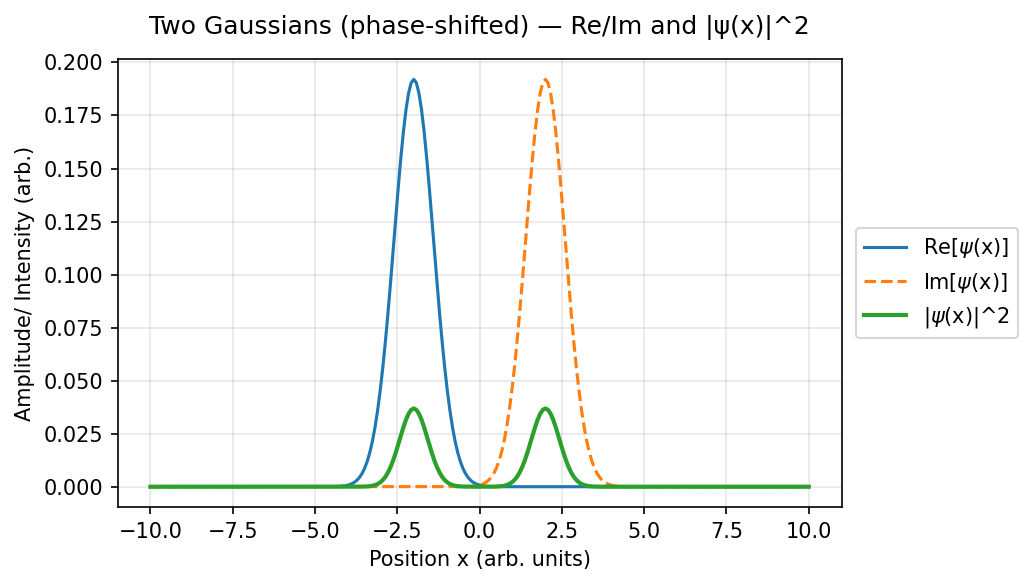

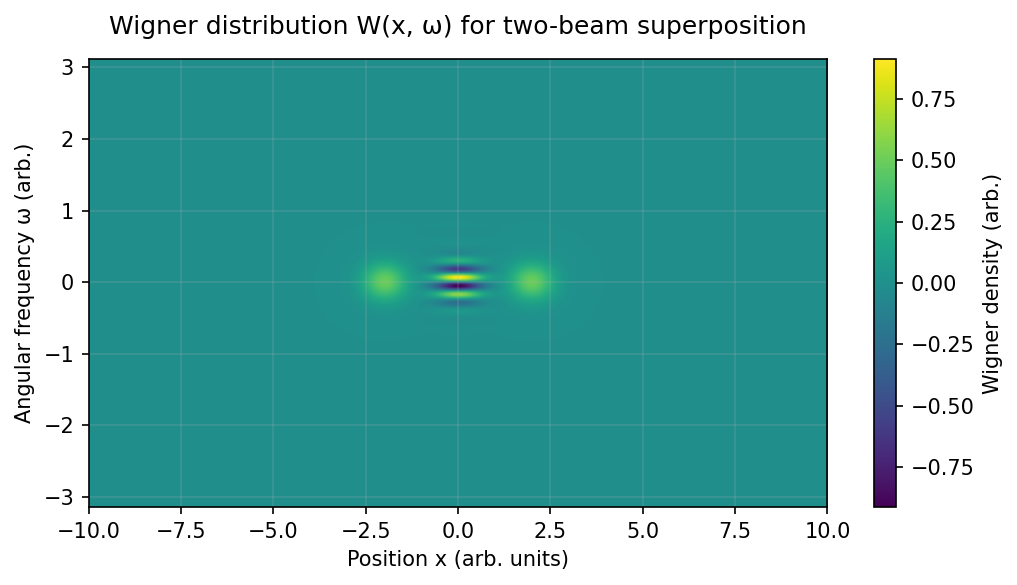

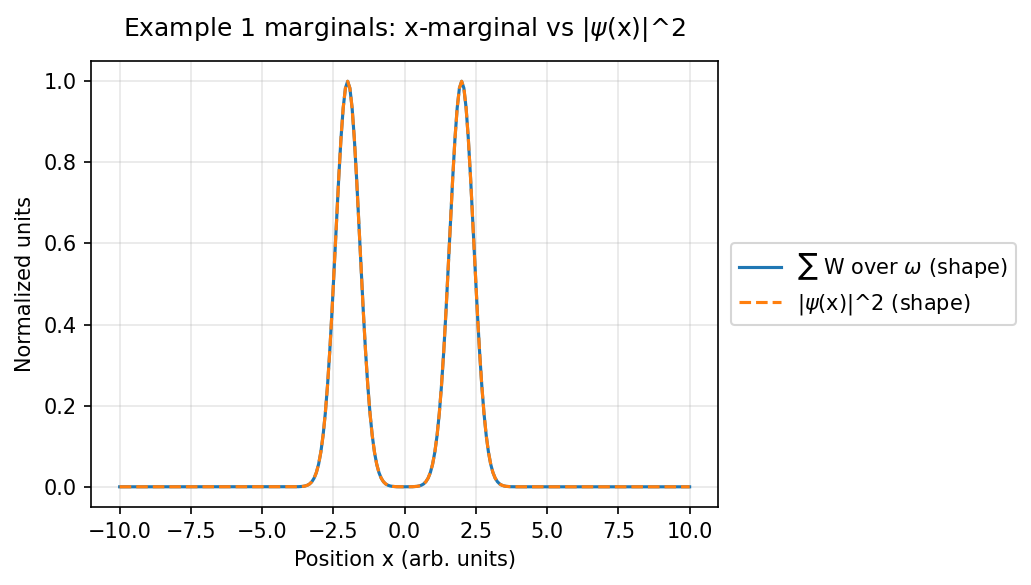

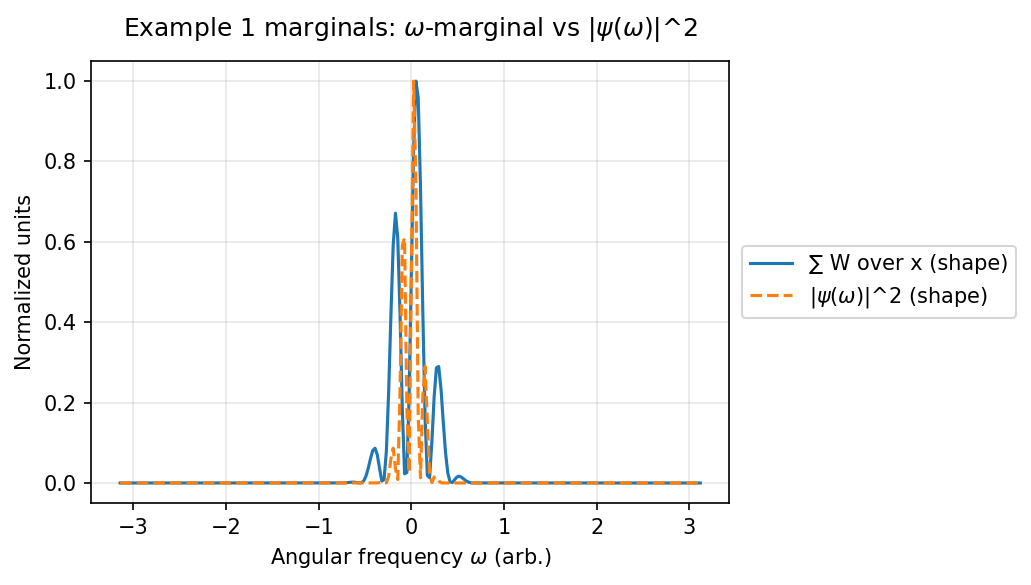

In [39]:
# @title 3) Example 1 — Two coherent Gaussians (computational interferometry, near field)
p = TwoGaussianParams(sigma=0.6, separation=4.0, phase_difference=np.pi/2)

g1 = gaussian_1d(x, -p.separation/2.0, p.sigma)
g2 = gaussian_1d(x,  p.separation/2.0, p.sigma) * np.exp(1j * p.phase_difference)
psi = normalize_wavefunction(g1 + g2)

# Visuals
plot_signal_and_intensity(x, psi, title="Two Gaussians (phase-shifted) — Re/Im and |ψ(x)|^2")

omega, W = wigner_wvd(psi)
plot_wigner(omega, x, W, title="Wigner distribution W(x, ω) for two-beam superposition",
            xlabel="Position x (arb. units)", ylabel="Angular frequency ω (arb.)")

overlay_marginals(x, omega, W, psi, title_prefix="Example 1 marginals")

delta = wigner_negativity_kenfack(W)
print(f"Wigner-negativity (Kenfack–Życzkowski proxy) for Example 1: δ ≈ {delta:.4f}")

Wigner-negativity (Kenfack–Życzkowski proxy) for Example 2: δ ≈ 0.3051


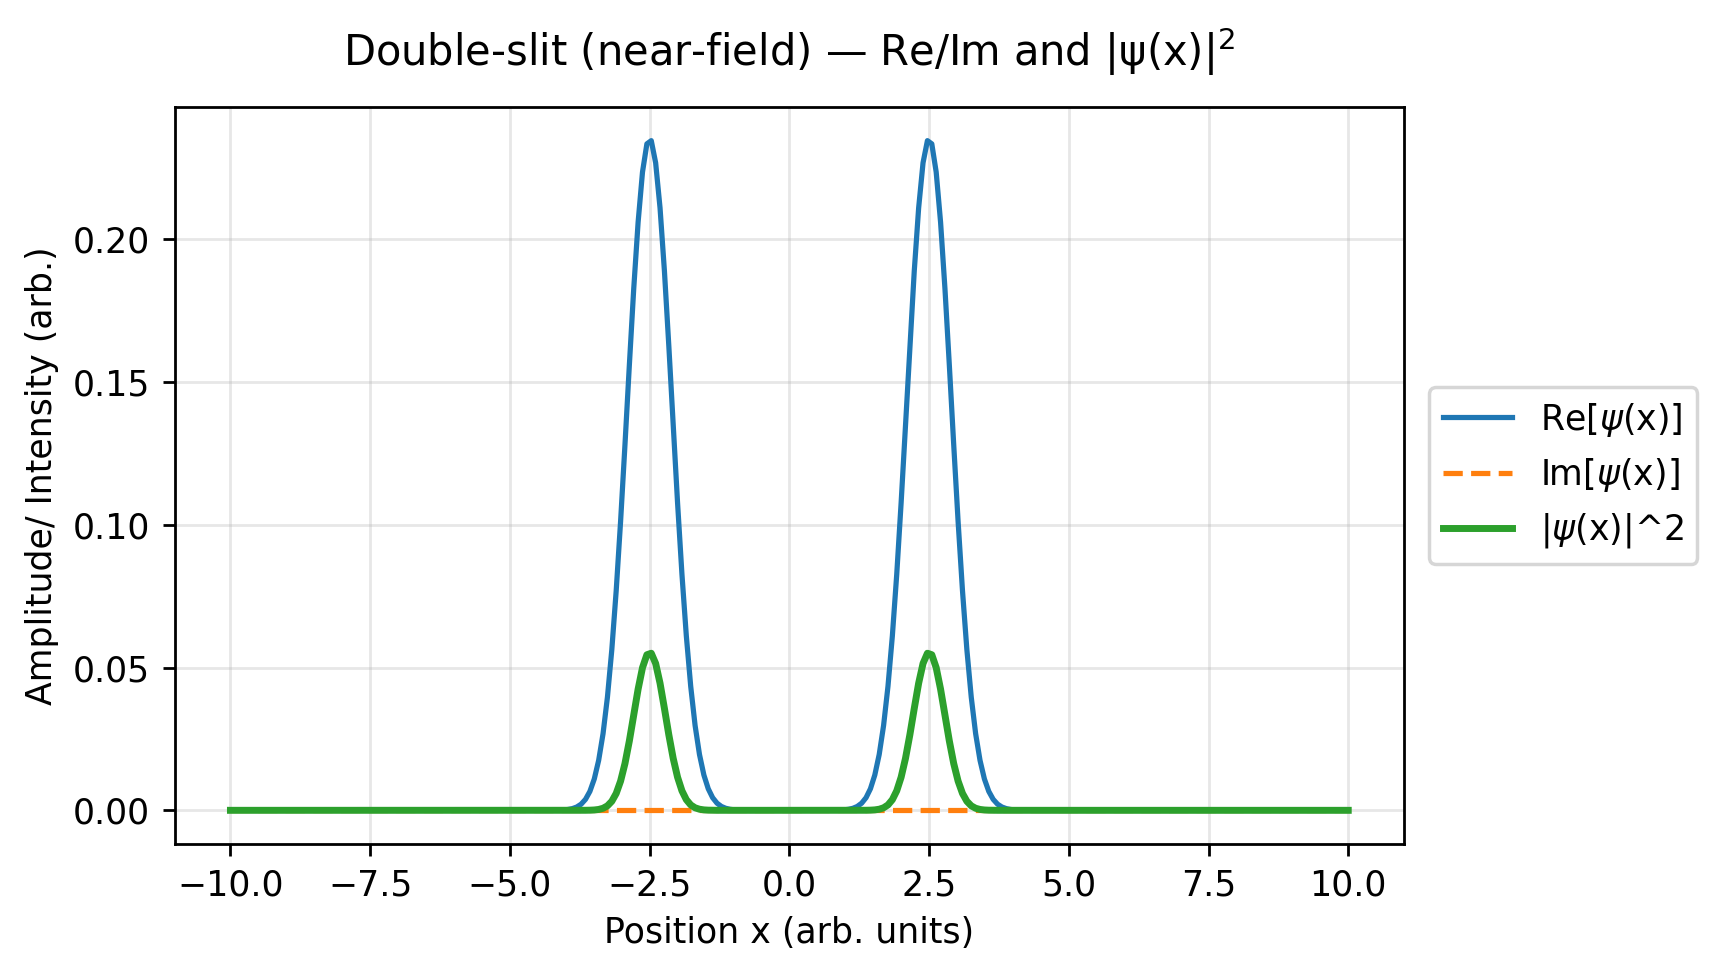

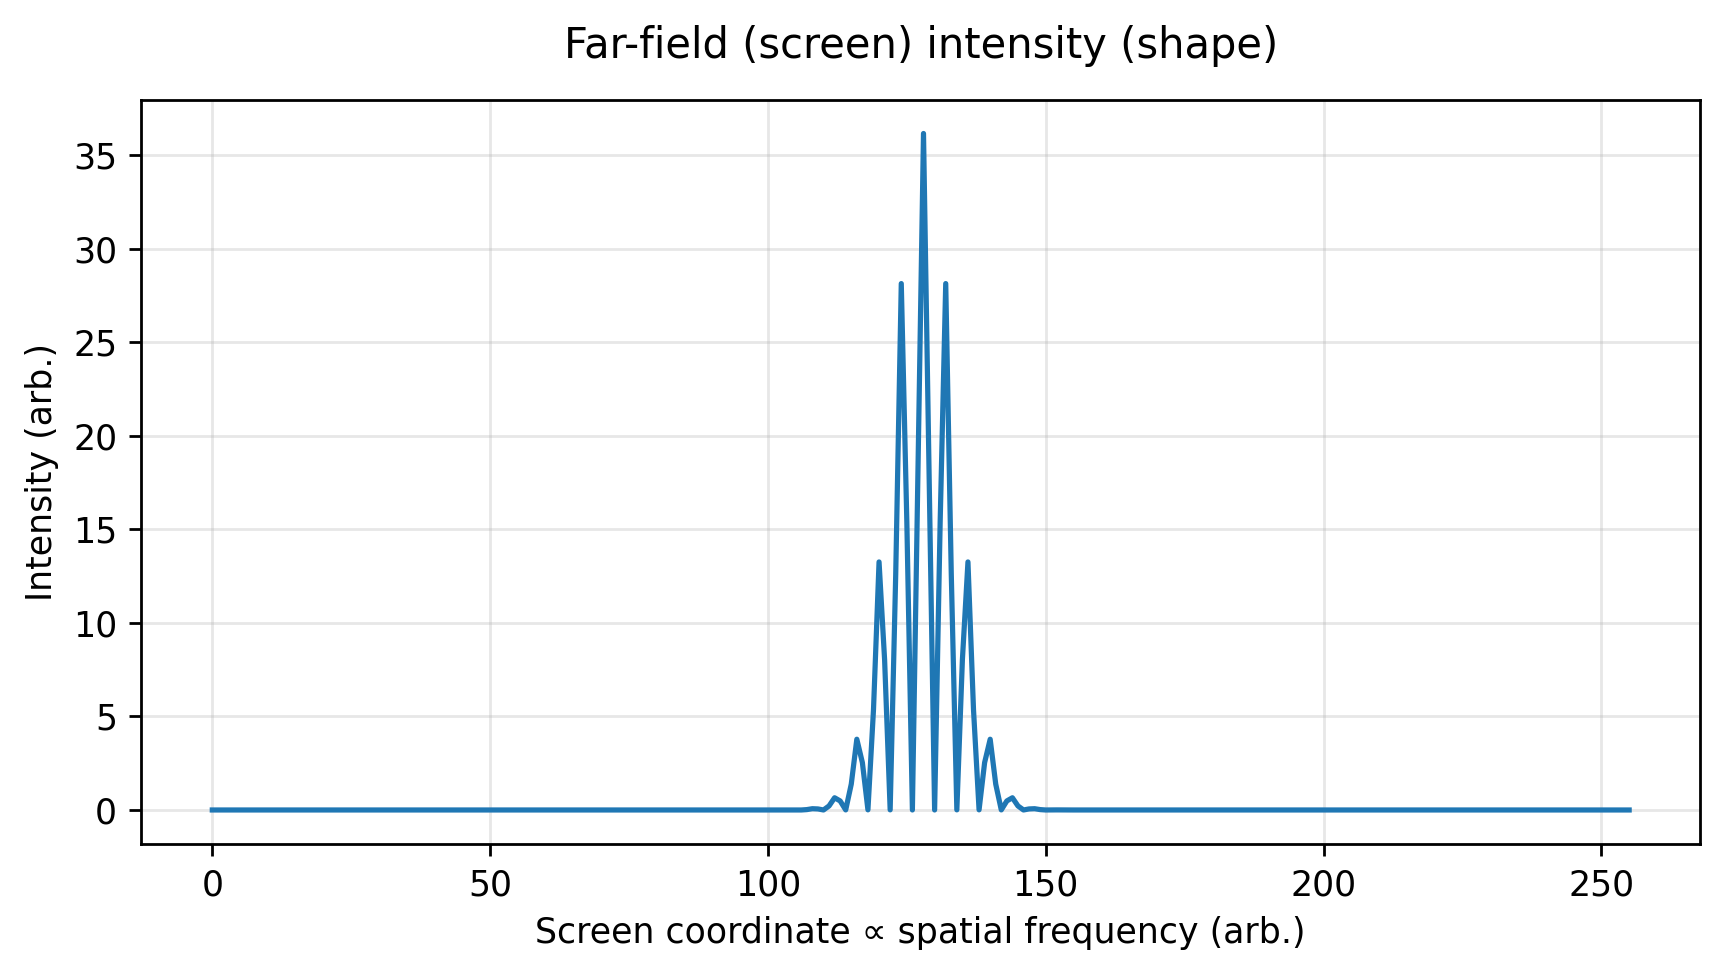

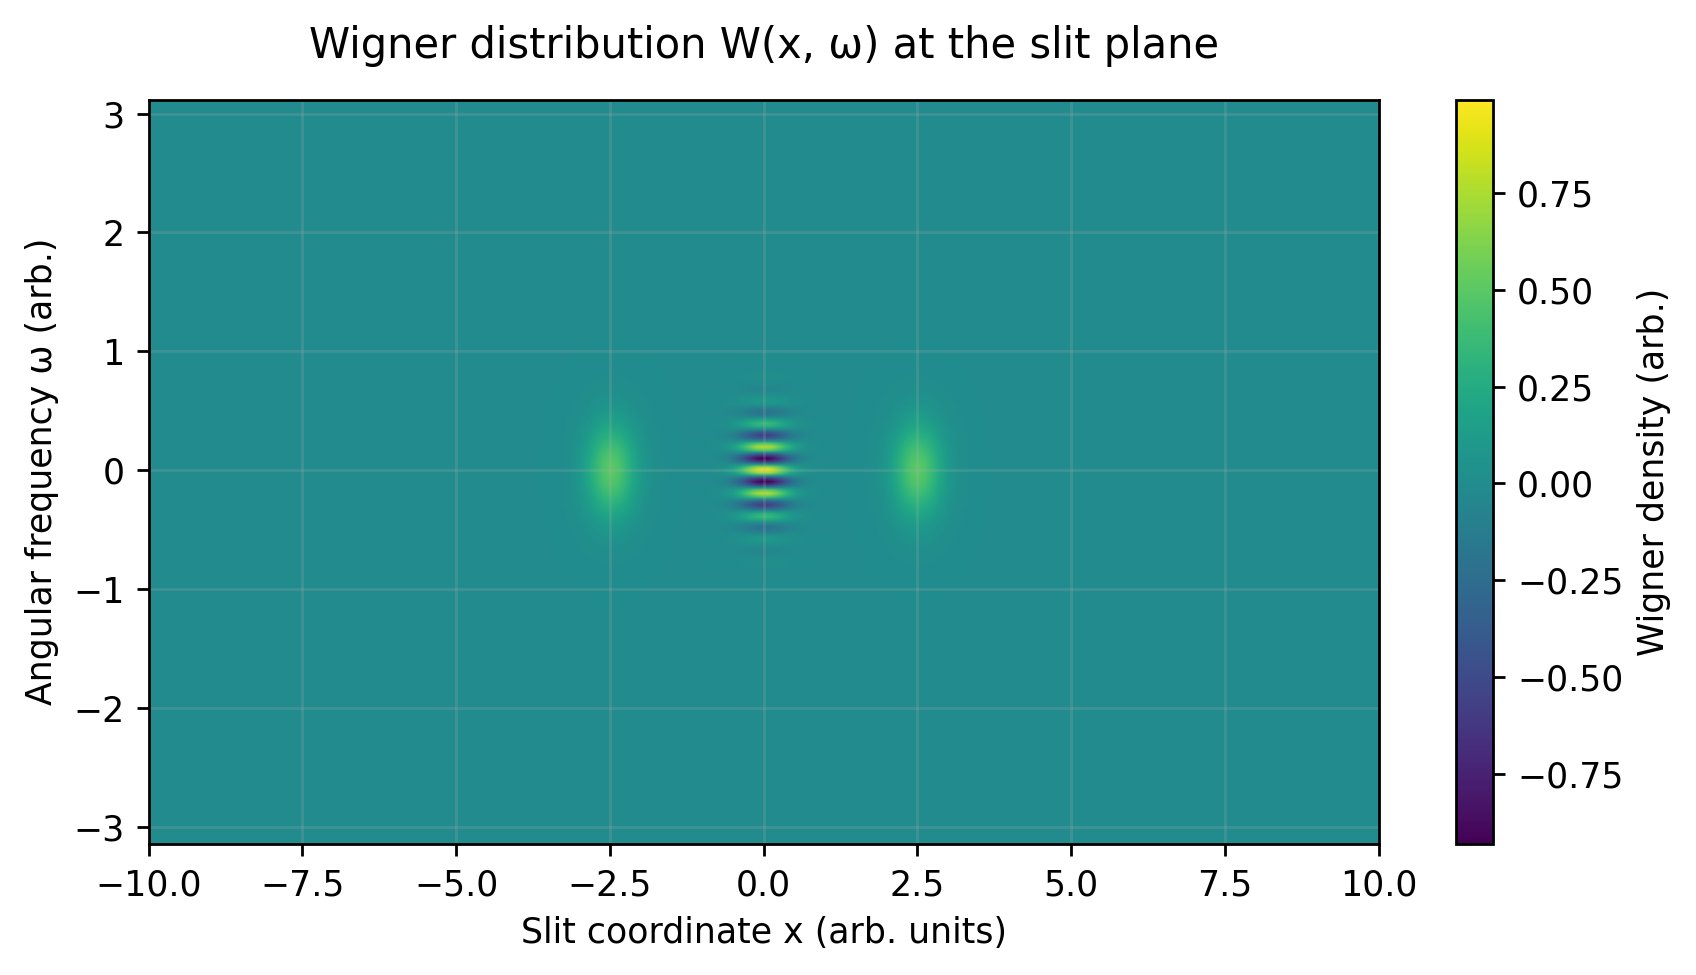

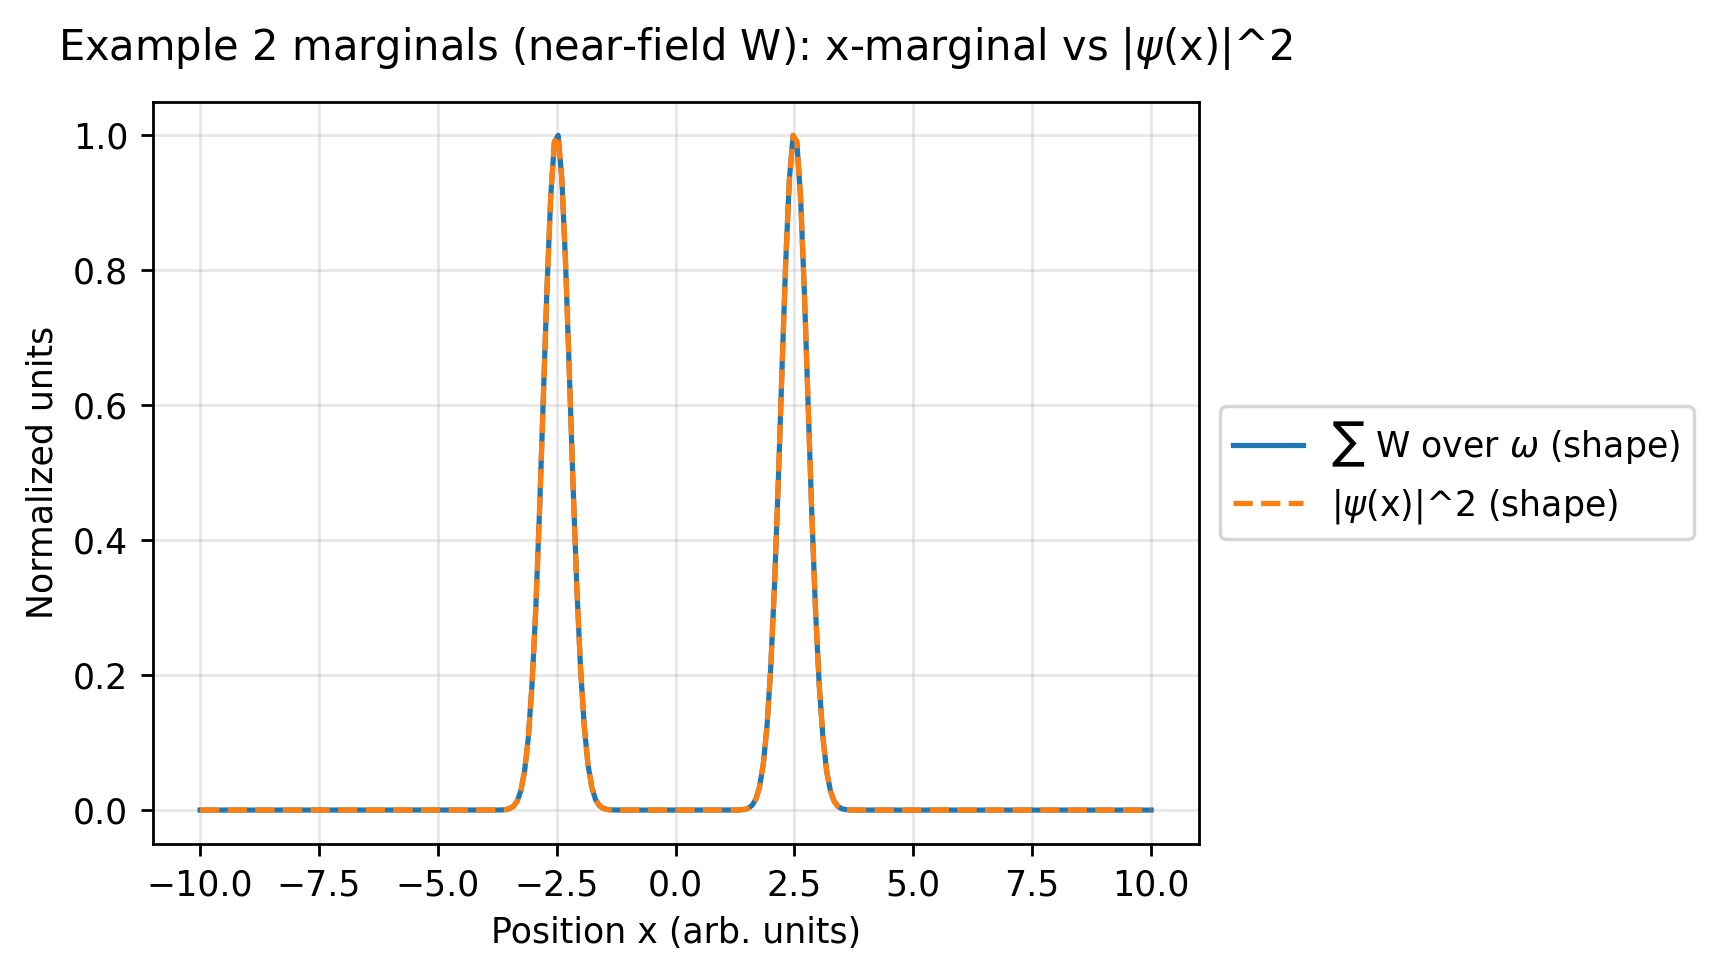

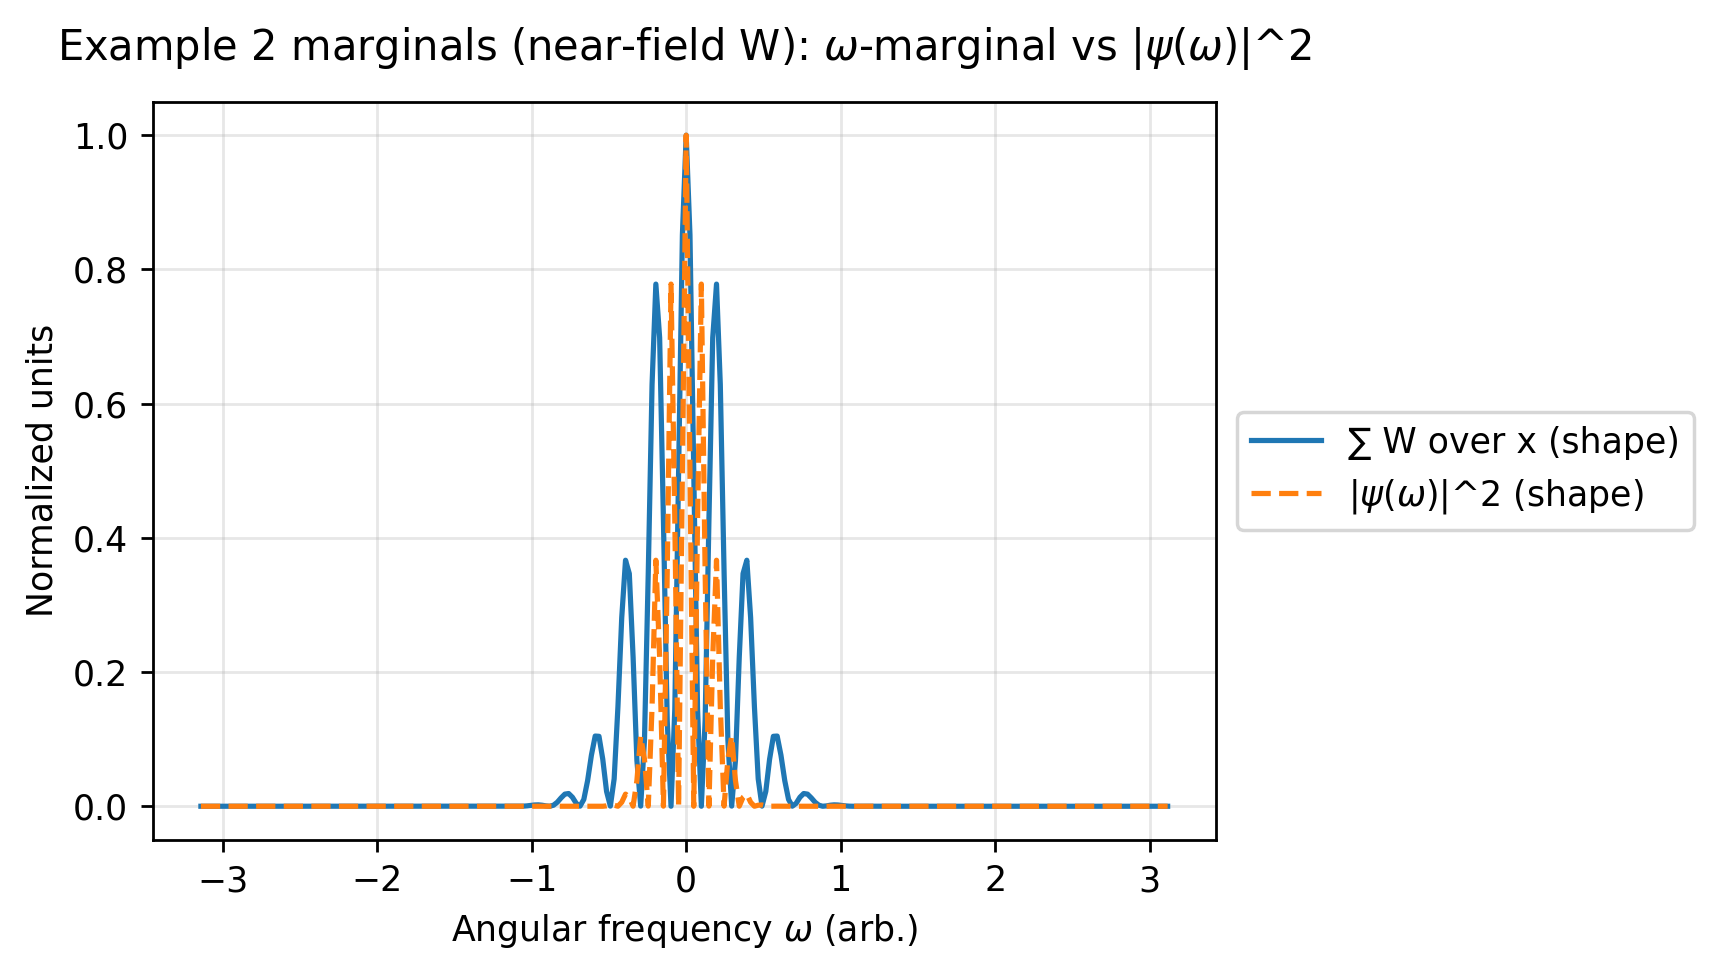

In [25]:
# @title 4) Example 2 — Double-slit: near-field Wigner + far-field pattern (FFT)
ds = DoubleSlitParams(width=0.4, separation=5.0, phase_difference=0.0)

psi_slit = normalize_wavefunction(make_double_slit(x, ds.separation, ds.width, ds.phase_difference))

# 4A. Intensity at the slits (near field)
plot_signal_and_intensity(x, psi_slit, title="Double-slit (near-field) — Re/Im and |ψ(x)|$^2$")

# 4B. Far-field (screen) intensity via FFT (shape)
A_far = far_field_fft(psi_slit)
fig, ax = plt.subplots(figsize=(7,4))
ax.set_title("Far-field (screen) intensity (shape)", pad=12)
ax.plot(np.abs(A_far)**2)
ax.set_xlabel("Screen coordinate ∝ spatial frequency (arb.)")
ax.set_ylabel("Intensity (arb.)")
ax.grid(alpha=0.3)
plt.tight_layout()

# 4C. Wigner of the near-field wavefunction (standard which-path vs. interference picture)
omega2, W2 = wigner_wvd(psi_slit)
plot_wigner(omega2, x, W2, title="Wigner distribution W(x, ω) at the slit plane",
            xlabel="Slit coordinate x (arb. units)", ylabel="Angular frequency ω (arb.)")

overlay_marginals(x, omega2, W2, psi_slit, title_prefix="Example 2 marginals (near-field W)")

delta2 = wigner_negativity_kenfack(W2)
print(f"Wigner-negativity (Kenfack–Życzkowski proxy) for Example 2: δ ≈ {delta2:.4f}")

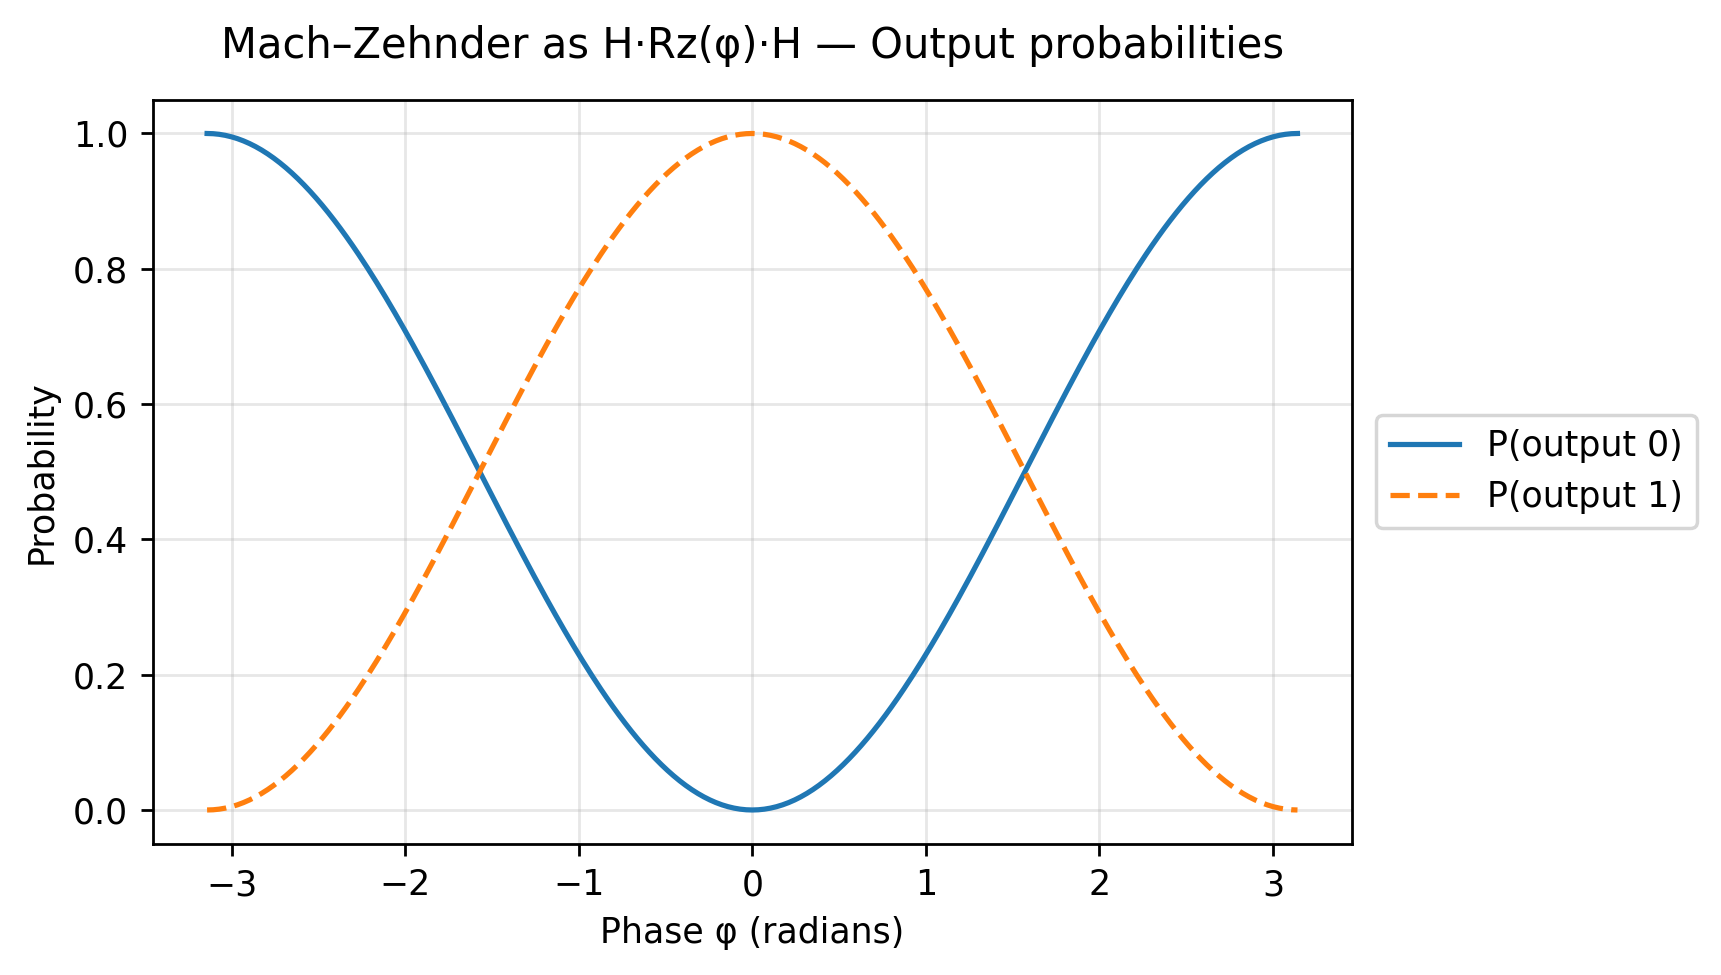

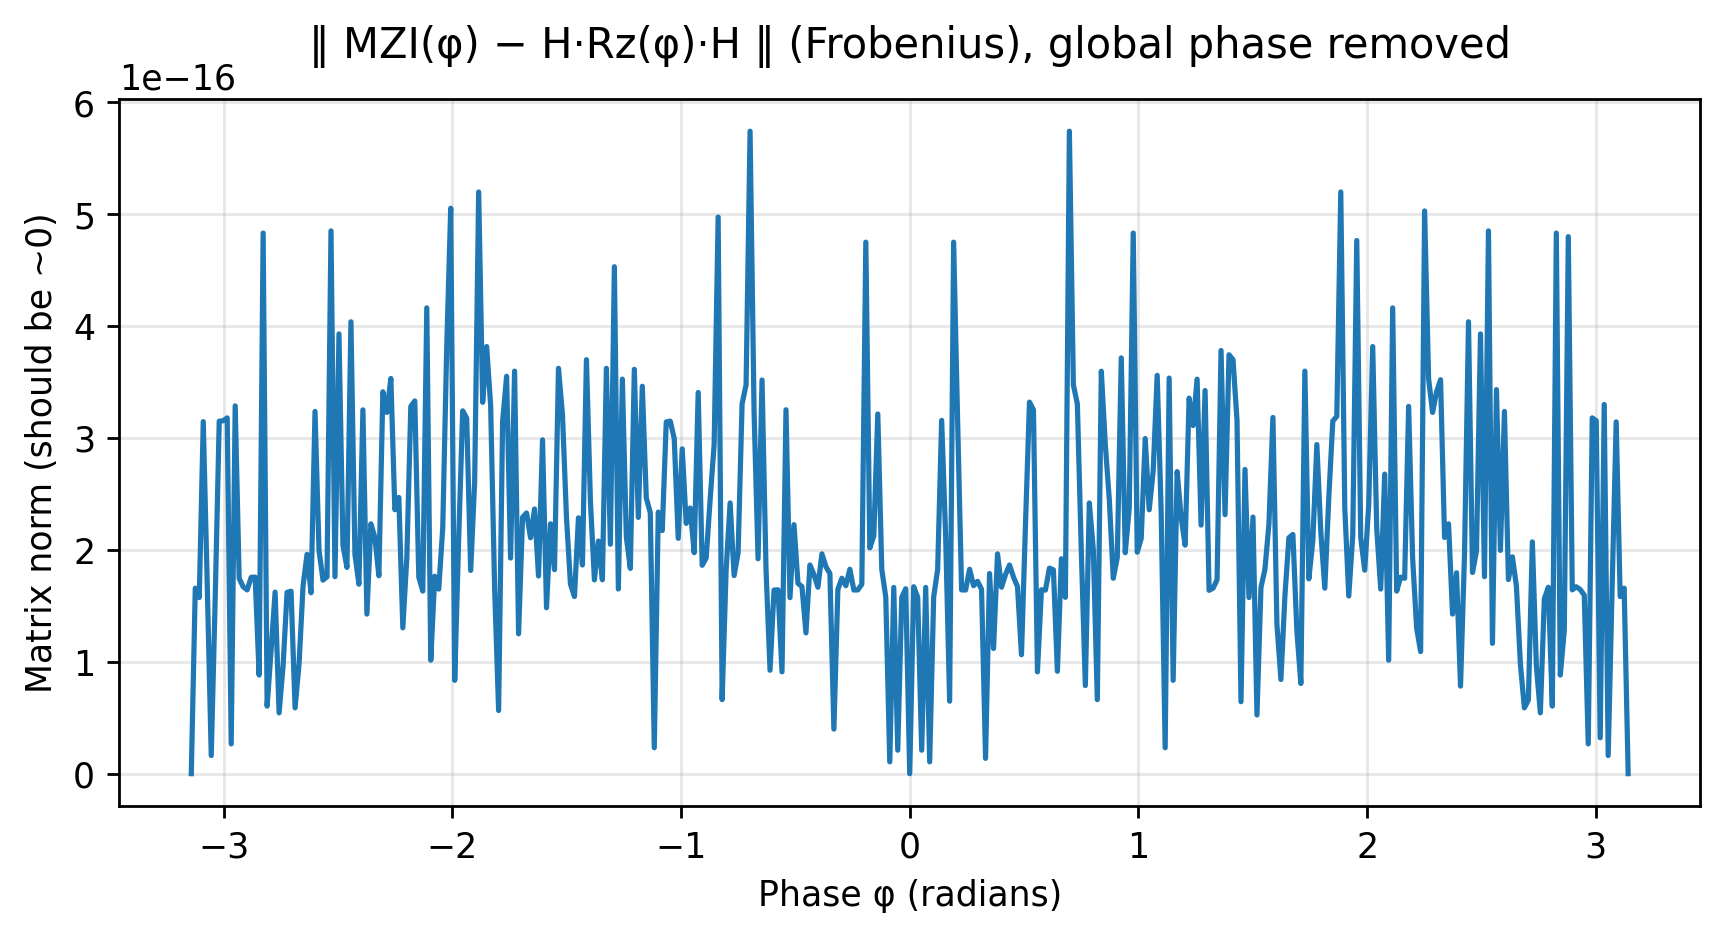

In [26]:
# @title 5) Mach–Zehnder as a single-qubit gate: H · Rz(φ) · H, output probabilities
phis = np.linspace(-np.pi, np.pi, 361)
P0, P1 = [], []
for phi in phis:
    U = mzi_unitary(phi)          # MZI transfer
    inp = np.array([0.0+0.0j, 1.0+0.0j])  # start in mode |1⟩
    out = U @ inp
    P0.append(np.abs(out[0])**2)
    P1.append(np.abs(out[1])**2)

fig, ax = plt.subplots(figsize=(7,4))
ax.set_title("Mach–Zehnder as H·Rz(φ)·H — Output probabilities", pad=12)
ax.plot(phis, P0, label="P(output 0)")
ax.plot(phis, P1, label="P(output 1)", linestyle="--")
ax.set_xlabel("Phase φ (radians)")
ax.set_ylabel("Probability")
ax.grid(alpha=0.3)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
plt.tight_layout()

# Validate equivalence (up to global phase) to H·Rz·H
def remove_global_phase(U):
    det = np.linalg.det(U)
    return U / np.sqrt(det) if det != 0 else U

errs = []
for phi in phis:
    U_mzi = remove_global_phase(mzi_unitary(phi))
    U_hrz = remove_global_phase(hadamard() @ rz(phi) @ hadamard())
    errs.append(np.linalg.norm(U_mzi - U_hrz))

fig2, ax2 = plt.subplots(figsize=(7,4))
ax2.set_title("‖ MZI(φ) − H·Rz(φ)·H ‖ (Frobenius), global phase removed", pad=12)
ax2.plot(phis, errs)
ax2.set_xlabel("Phase φ (radians)")
ax2.set_ylabel("Matrix norm (should be ~0)")
ax2.grid(alpha=0.3)
plt.tight_layout()

δ range over φ: [0.2998, 0.3134]


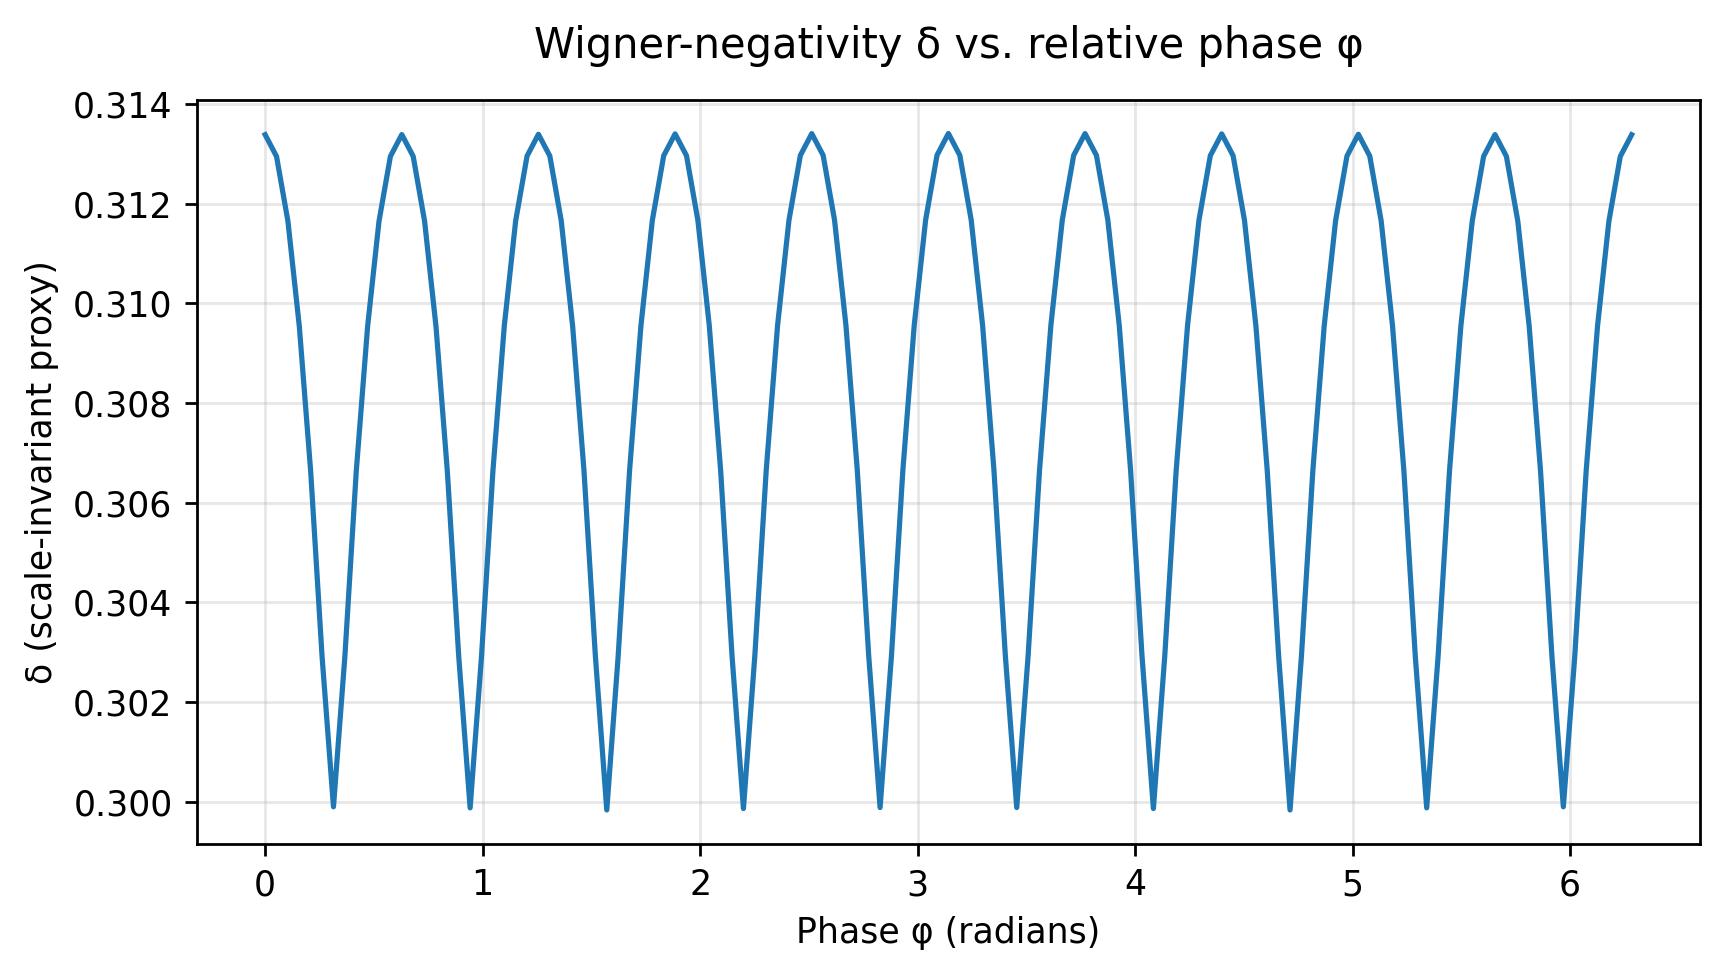

In [27]:
# @title 6) Wigner-negativity vs. relative phase between the two paths
sigma = 0.6
separation = 4.0
g1 = gaussian_1d(x, -separation/2.0, sigma)
g2 = gaussian_1d(x,  separation/2.0, sigma)

phis = np.linspace(0, 2*np.pi, 121)
neg = []
for phi in phis:
    psi = normalize_wavefunction(g1 + g2 * np.exp(1j*phi))
    _, Wp = wigner_wvd(psi)
    neg.append(wigner_negativity_kenfack(Wp))

fig, ax = plt.subplots(figsize=(7,4))
ax.set_title("Wigner-negativity δ vs. relative phase φ", pad=12)
ax.plot(phis, neg)
ax.set_xlabel("Phase φ (radians)")
ax.set_ylabel("δ (scale-invariant proxy)")
ax.grid(alpha=0.3)
plt.tight_layout()
print(f"δ range over φ: [{np.min(neg):.4f}, {np.max(neg):.4f}]")

(<Figure size 1750x1000 with 2 Axes>,
 <Axes: title={'center': 'Cross-Wigner: Im[W(g1, g2)]'}, xlabel='Position x (arb. units)', ylabel='Angular frequency ω (arb.)'>)

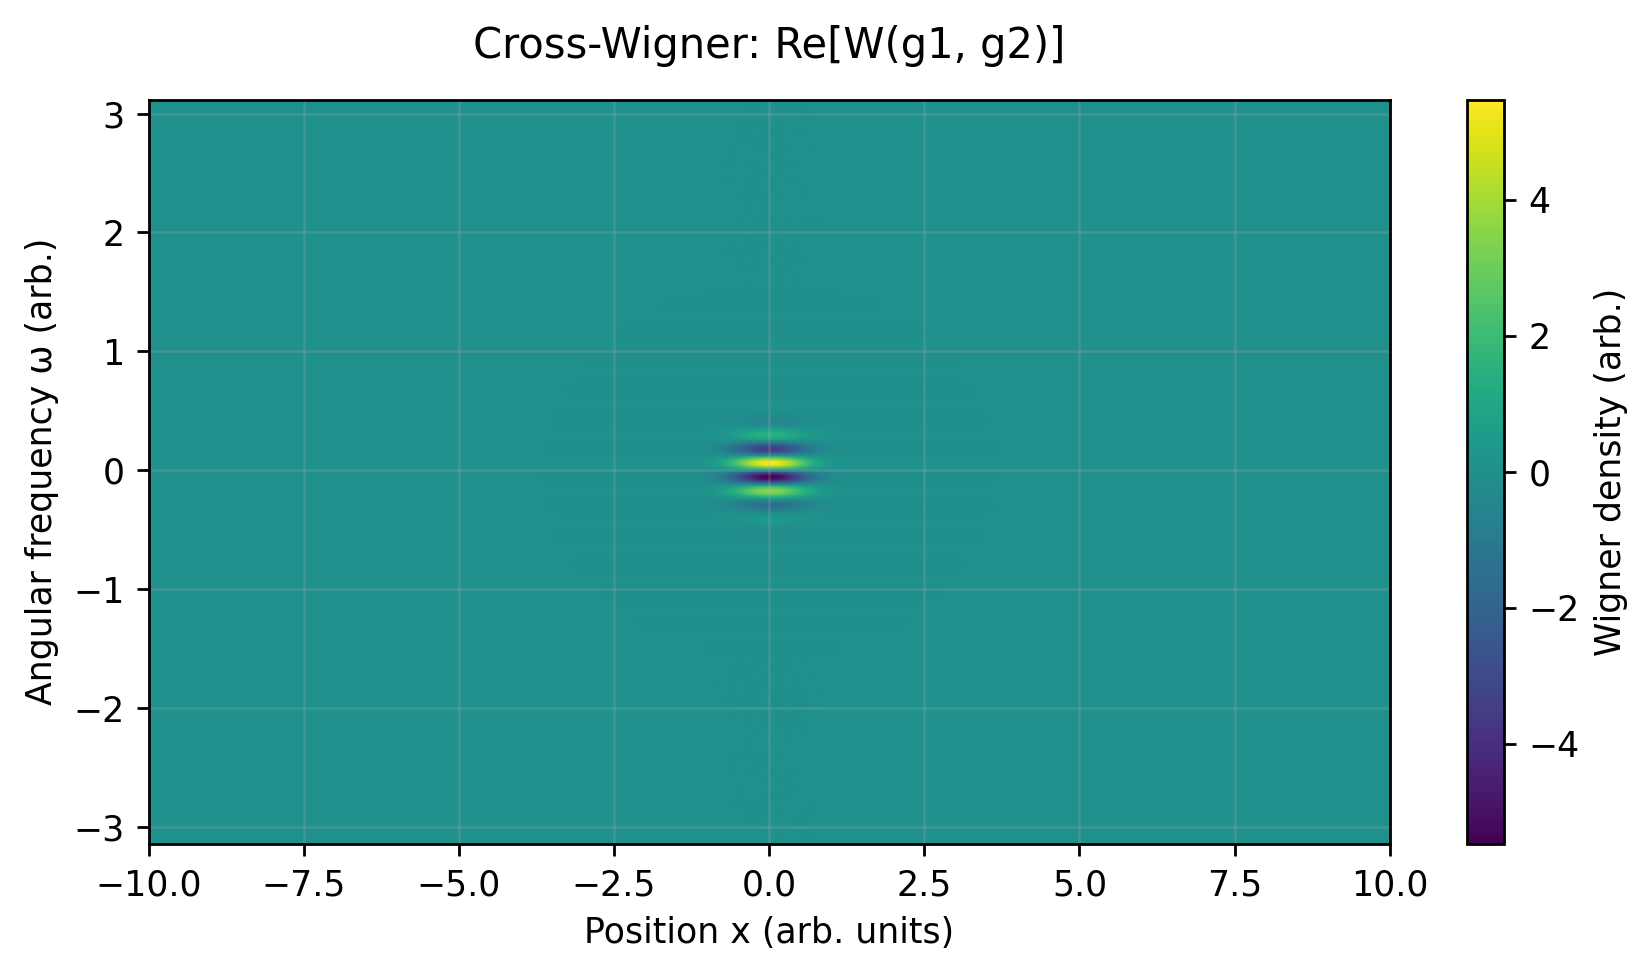

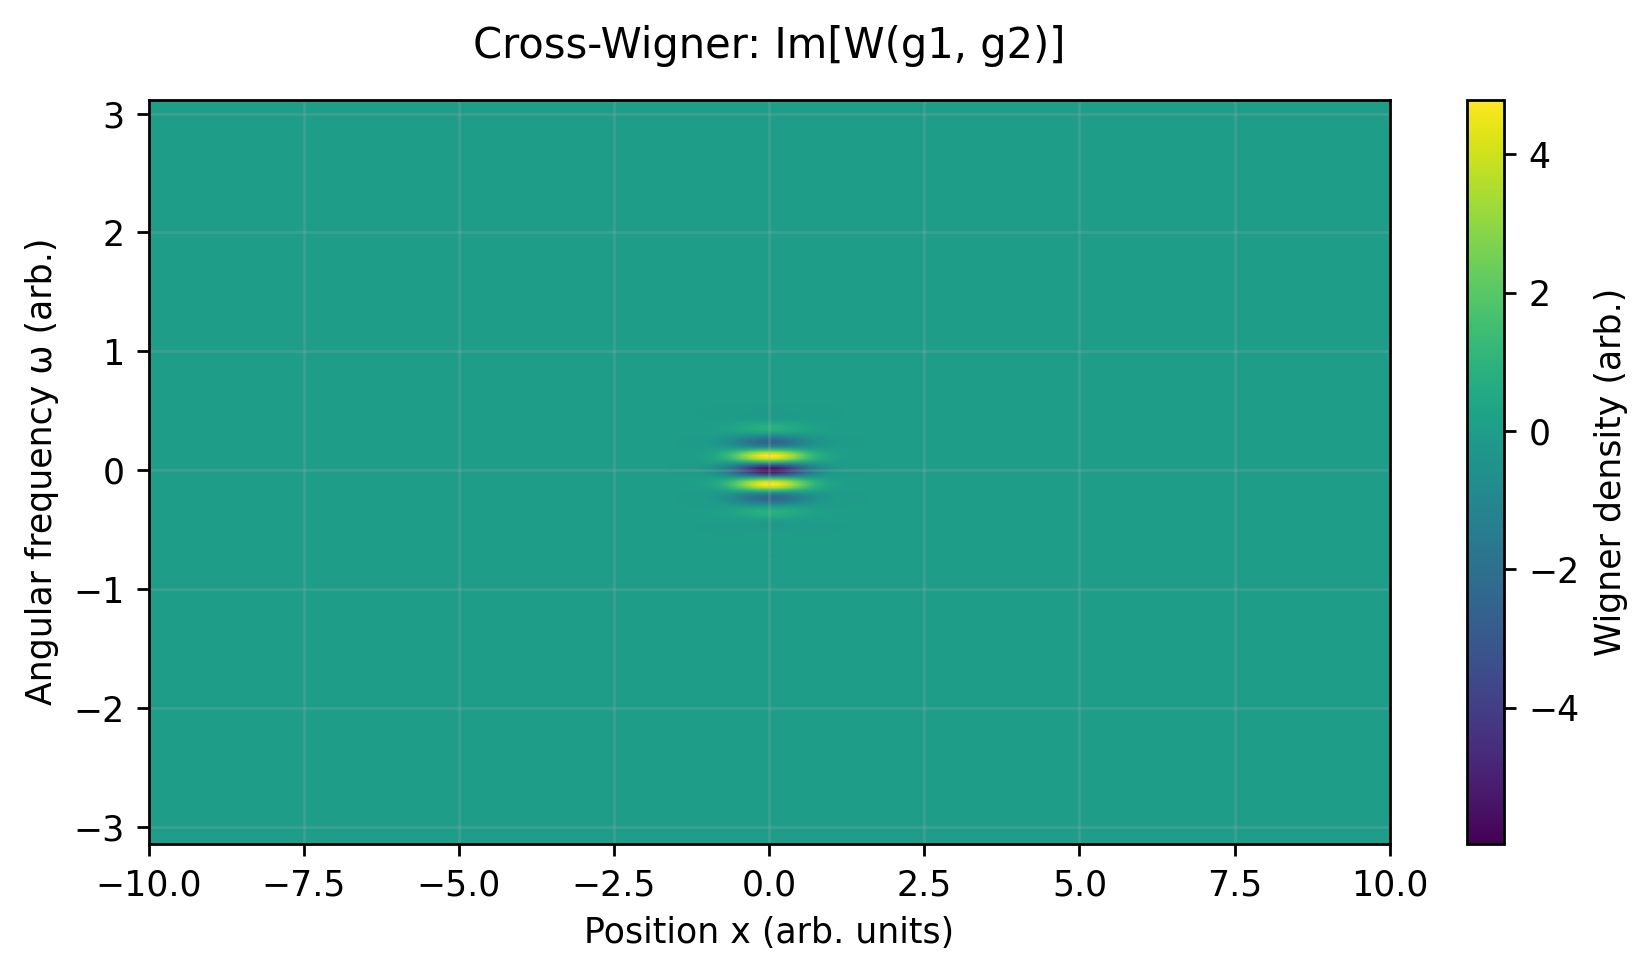

In [28]:
# @title 7) Cross-Wigner to isolate the interference term (real & imaginary)
phi_demo = np.pi/2
g1_demo = gaussian_1d(x, -separation/2.0, sigma)
g2_demo = gaussian_1d(x,  separation/2.0, sigma) * np.exp(1j*phi_demo)
omega_c, Wc = cross_wigner_wvd(g1_demo, g2_demo)

# Real part
plot_wigner(omega_c, x, np.real(Wc), title="Cross-Wigner: Re[W(g1, g2)]",
            xlabel="Position x (arb. units)", ylabel="Angular frequency ω (arb.)")

# Imag part
plot_wigner(omega_c, x, np.imag(Wc), title="Cross-Wigner: Im[W(g1, g2)]",
            xlabel="Position x (arb. units)", ylabel="Angular frequency ω (arb.)")

In [ ]:
# @title 8) Pylint — quick quality pass on the module (relaxed docstring checks)
!pylint -sn -rn --disable=C0114,C0115,C0116,R0902,R0914,R0915 wigner_qc_tools.py

In [40]:
# @title 9) A compact glossary + references
print("Acronym Glossary")
print("WVD — Wigner–Ville distribution (time/space–frequency bilinear representation).")
print("MZI — Mach–Zehnder interferometer (beam splitter – phase – beam splitter).")
print("Rz(φ) — Single-qubit Z rotation by φ.")
print("H — Hadamard gate.")
print("Cross-Wigner — Bilinear transform of two different signals, isolates interference.")
print("Wigner negativity δ — Volume of negative regions (scale-normalized proxy).")

print("\nOpen-access references (short list):")
print("O’Connell, R.F., “The Wigner Distribution,” arXiv:1009.4431.")
print("Pietersoone et al., “Simulation of diffraction and scattering using the Wigner Distribution Function,” arXiv:2403.05684.")
print("Dragoman, “The interference term in the Wigner distribution function and the Aharonov–Bohm effect,” arXiv:quant-ph/0402168.")
print("Marinho et al., “Gouy phase and quantum interference with cross-Wigner functions,” arXiv:2401.00083.")
print("Cleve et al., “Quantum algorithms revisited” (interferometers as algorithms), arXiv:quant-ph/9903061.")
print("Shadbolt et al., “Generating, manipulating and measuring multi-photon states…,” arXiv:1108.3309.")
print("Kenfack & Życzkowski, “Negativity of the Wigner function as an indicator of nonclassicality,” arXiv:quant-ph/0406015.")
print("Veitch et al., “Negative quasi-probability as a resource for quantum computation,” arXiv:1201.1256.")

Acronym Glossary
WVD — Wigner–Ville distribution (time/space–frequency bilinear representation).
MZI — Mach–Zehnder interferometer (beam splitter – phase – beam splitter).
Rz(φ) — Single-qubit Z rotation by φ.
H — Hadamard gate.
Cross-Wigner — Bilinear transform of two different signals, isolates interference.
Wigner negativity δ — Volume of negative regions (scale-normalized proxy).

Open-access references (short list):
O’Connell, R.F., “The Wigner Distribution,” arXiv:1009.4431.
Pietersoone et al., “Simulation of diffraction and scattering using the Wigner Distribution Function,” arXiv:2403.05684.
Dragoman, “The interference term in the Wigner distribution function and the Aharonov–Bohm effect,” arXiv:quant-ph/0402168.
Marinho et al., “Gouy phase and quantum interference with cross-Wigner functions,” arXiv:2401.00083.
Cleve et al., “Quantum algorithms revisited” (interferometers as algorithms), arXiv:quant-ph/9903061.
Shadbolt et al., “Generating, manipulating and measuring multi-pho

Next section of code focuses on an extended custom example for the analogy.

```
Two-Qubit “Computational Interferometry”
├─ Gate layer
│  ├─ H(q0) → CNOT(q0→q1) → Bell pair |Ψ⁺⟩
│  ├─ Decoder = adjoint of encoder → computational basis readout
│  └─ Pauli correlators → XX, YY, ZZ → fidelity FΨ⁺ exact
├─ Quantum phase space
│  ├─ Discrete Wigner (qubits) → phase-point operators (Pauli-based)
│  ├─ 4×4 DWF heatmap → negativity as nonclassicality/magic
│  └─ Gauge caveats in even d; still pedagogically standard
└─ Classical comparison
   ├─ Pseudo-Wigner–Ville (time–frequency) → cross-terms & fringes
   └─ Keeps optics intuition, but not a qubit quasi-probability
```

```
q0: |0> --H------*-----Ry(π/4)----Rz(π/2)--------H-----*----[MZ]
                 |                                     |
q1: |1> ---------X-----Ry(π/4)----Rz(π/2)--------------X----[MZ]

```

In [31]:
#@title Write `two_qubit_tools.py`
# This cell creates a reusable module with:
# - Explicit H targeting (q0 vs q1),
# - Bell-basis decoder (inverse of H(q0)→CNOT(q0→q1)),
# - Pauli correlators + Ψ⁺ fidelity witness,
# - Proper discrete 2-qubit Wigner function (4×4),
# - Classical pseudo–Wigner–Ville distribution (for comparison),
# - Plotting helpers and a demo driver.

from textwrap import dedent

module_code = """# -*- coding: utf-8 -*-
# two_qubit_tools.py
# pylint: disable=invalid-name,too-many-arguments
\"\"\"Lightweight utilities for two-qubit interferometry-style simulations.

Features
--------
- Correct, explicit targeting for single-qubit gates on q0 vs q1.
- Optional Bell-basis \"decoder\" (inverse of H on control + CNOT) for Ψ-type
  entanglement prepared with H(q0) → CNOT(q0→q1).
- Pauli correlators and a simple fidelity witness for |Ψ+>.
- Proper discrete Wigner function (DWF) for 2 qubits (4×4 grid) built
  from tensor products of single-qubit phase-point operators A_{q,p}.
  This is distinct from the classical Wigner-Ville Distribution (WVD).
- Classical 1D pseudo-Wigner-Ville (time–frequency) for a surrogate signal.

Basis & Ordering
----------------
We use computational basis ordering |q0 q1> → [|00>, |01>, |10>, |11>].
\"\"\"

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Tuple, List

import numpy as np
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
import pandas as pd

# ---------- Linear algebra basics ----------

def dm(psi: np.ndarray) -> np.ndarray:
    \"\"\"Density matrix rho = |psi><psi| for a state vector psi (shape: (4,)).\"\"\"
    psi = np.asarray(psi, dtype=np.complex128).reshape(-1)
    return np.outer(psi, np.conjugate(psi))

def tensor(*ops: np.ndarray) -> np.ndarray:
    \"\"\"Kronecker product of a sequence of operators.\"\"\"
    out = np.array([[1.0+0.0j]])
    for op in ops:
        out = np.kron(out, op)
    return out

# ---------- Pauli operators ----------

I2 = np.array([[1, 0], [0, 1]], dtype=np.complex128)
X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)

# ---------- Basis utilities ----------

basis_labels = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]

def ket(label: str) -> np.ndarray:
    \"\"\"Return computational basis ket vector for '00','01','10','11'.\"\"\"
    mapping = {"00": 0, "01": 1, "10": 2, "11": 3}
    idx = mapping[label]
    v = np.zeros(4, dtype=np.complex128)
    v[idx] = 1.0 + 0.0j
    return v

# ---------- Gate constructors (2 qubits) ----------

H1 = (1.0 / np.sqrt(2.0)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)

def gate_H(qubit: int) -> np.ndarray:
    \"\"\"Hadamard on the chosen qubit (0 or 1) of a 2-qubit system.\"\"\"
    return tensor(H1, I2) if qubit == 0 else tensor(I2, H1)

def gate_Ry(theta: float, qubit: int) -> np.ndarray:
    \"\"\"R_y on chosen qubit.\"\"\"
    c = np.cos(theta / 2.0)
    s = np.sin(theta / 2.0)
    Ry = np.array([[c, -s], [s, c]], dtype=np.complex128)
    return tensor(Ry, I2) if qubit == 0 else tensor(I2, Ry)

def gate_Rz(phi: float, qubit: int) -> np.ndarray:
    \"\"\"R_z on chosen qubit.\"\"\"
    Rz = np.array(
        [[np.exp(-1j * phi / 2.0), 0], [0, np.exp(1j * phi / 2.0)]],
        dtype=np.complex128,
    )
    return tensor(Rz, I2) if qubit == 0 else tensor(I2, Rz)

def gate_CNOT(control: int, target: int) -> np.ndarray:
    \"\"\"CNOT with given control and target (distinct, in {0,1}).\"\"\"
    if control == target or control not in (0, 1) or target not in (0, 1):
        raise ValueError("control and target must be distinct qubits 0 or 1")
    if control == 0 and target == 1:
        # |00>→|00>, |01>→|01>, |10>→|11>, |11>→|10>
        return np.array(
            [[1, 0, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 0, 1],
             [0, 0, 1, 0]], dtype=np.complex128
        )
    # control=1, target=0
    return np.array(
        [[1, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 1, 0],
         [0, 1, 0, 0]], dtype=np.complex128
    )

# ---------- Expectations & correlators ----------

def exp_psi(psi: np.ndarray, op: np.ndarray) -> complex:
    \"\"\"<psi| op |psi> for state vector psi.\"\"\"
    return np.vdot(psi, op @ psi)

def exp_rho(rho: np.ndarray, op: np.ndarray) -> complex:
    \"\"\"Tr(rho op).\"\"\"
    return np.trace(rho @ op)

def pauli_correlators(psi: np.ndarray) -> Dict[str, float]:
    \"\"\"Return <X⊗X>, <Y⊗Y>, <Z⊗Z> as real floats.\"\"\"
    XX = tensor(X, X)
    YY = tensor(Y, Y)
    ZZ = tensor(Z, Z)
    E_xx = float(np.real(exp_psi(psi, XX)))
    E_yy = float(np.real(exp_psi(psi, YY)))
    E_zz = float(np.real(exp_psi(psi, ZZ)))
    return {"E_xx": E_xx, "E_yy": E_yy, "E_zz": E_zz}

def fidelity_Psi_plus(psi: np.ndarray) -> float:
    r\"\"\"Estimate fidelity with |Ψ+> using Pauli correlators:
    F_{Ψ+} = (1 + <X⊗X> + <Y⊗Y> − <Z⊗Z>)/4.
    \"\"\"
    cors = pauli_correlators(psi)
    F = (1.0 + cors["E_xx"] + cors["E_yy"] - cors["E_zz"]) / 4.0
    return float(F)

# ---------- Bell \"decoder\" (inverse of H(q0)→CNOT(q0→q1)) ----------

def bell_decoder_for_Hq0_CNOTq0to1() -> np.ndarray:
    \"\"\"Unitary that maps Bell states back to computational basis
    for entanglement prepared by H(q0) then CNOT(q0→q1):
    U_decode = H(q0) · CNOT(q0→q1).
    Apply as |psi_dec> = U_decode |psi> before Z⊗Z measurement.
    \"\"\"
    return gate_H(0) @ gate_CNOT(0, 1)

# ---------- Classical pseudo-Wigner-Ville (WVD) ----------

def gaussian(x: np.ndarray, x0: float, sigma: float) -> np.ndarray:
    \"\"\"Real Gaussian centered at x0 with std sigma.\"\"\"
    return np.exp(-0.5 * ((x - x0) / sigma) ** 2)

def state_to_signal(
    state: np.ndarray, x_coords: np.ndarray, positions: List[float], sigma: float
) -> np.ndarray:
    \"\"\"Map 4-amp state to a 1D complex surrogate signal by placing Gaussians.\"\"\"
    signal = np.zeros_like(x_coords, dtype=np.complex128)
    for i, amp in enumerate(state.reshape(-1)):
        if np.abs(amp) > 0.0:
            signal += amp * gaussian(x_coords, positions[i], sigma)
    return signal

def wigner_ville_1d(signal: np.ndarray) -> np.ndarray:
    \"\"\"Discrete pseudo-Wigner-Ville distribution (time–frequency).\"\"\"
    N = len(signal)
    pad = np.pad(signal, (N // 2, N // 2), mode="constant")
    wvd = np.zeros((N, N), dtype=np.complex128)
    m_range = np.arange(-N // 2, N // 2)
    for n in range(N):
        kernel = np.zeros(N, dtype=np.complex128)
        for m_idx, m in enumerate(m_range):
            i1 = n + N // 2 + m
            i2 = n + N // 2 - m
            if 0 <= i1 < len(pad) and 0 <= i2 < len(pad):
                kernel[m_idx] = pad[i1] * np.conjugate(pad[i2])
        wvd[:, n] = fft(kernel)
    return fftshift(wvd, axes=0)

# ---------- Discrete Wigner function (DWF) for two qubits ----------
# Single-qubit phase-point operators:
#   A_{q,p} = 1/2 [ I + (-1)^q Z + (-1)^p X + (-1)^{q+p} Y ]
# Two-qubit kernel is tensor product: A_{α1} ⊗ A_{α2}, αj=(qj,pj)∈{0,1}^2.
# DWF values: W(α1,α2) = (1/4) Tr[ ρ · (A_{α1} ⊗ A_{α2}) ]
# Summation over all 16 phase points yields 1. Negativity can be quantified.

def phase_point_operator(q: int, p: int) -> np.ndarray:
    \"\"\"Single-qubit A_{q,p} operator (2×2, Hermitian, not PSD in general).\"\"\"
    return 0.5 * (I2 + ((-1) ** q) * Z + ((-1) ** p) * X + ((-1) ** (q + p)) * Y)

def dwf_two_qubits(rho: np.ndarray) -> np.ndarray:
    \"\"\"Return 4×4 array with rows,cols indexed by (q,p) in [00,01,10,11].\"\"\"
    rho = np.asarray(rho, dtype=np.complex128).reshape(4, 4)
    pts = [(0, 0), (0, 1), (1, 0), (1, 1)]
    W = np.zeros((4, 4), dtype=float)
    for i, (q1, p1) in enumerate(pts):
        A1 = phase_point_operator(q1, p1)
        for j, (q2, p2) in enumerate(pts):
            A2 = phase_point_operator(q2, p2)
            A = tensor(A1, A2)
            W[i, j] = float(np.real(np.trace(rho @ A) / 4.0))
    return W

def dwf_negativity(W: np.ndarray) -> float:
    \"\"\"Total negativity δ(W) = (sum |W| - 1)/2.\"\"\"
    return float((np.sum(np.abs(W)) - 1.0) / 2.0)

# ---------- Plotting helpers ----------

def plot_wvd_row(fig: plt.Figure, xs: np.ndarray, ks: np.ndarray,
                 panels: List[Tuple[np.ndarray, str]],
                 basis_ticks: List[float], basis_ticklabels: List[str]) -> None:
    \"\"\"Plot a row of WVD panels with colorbars.\"\"\"
    for idx, (wvd, title) in enumerate(panels, start=1):
        ax = fig.add_subplot(1, len(panels), idx)
        im = ax.imshow(
            np.real(wvd), aspect="auto", cmap="RdBu_r", interpolation="bilinear",
            extent=[xs[0], xs[-1], ks[0], ks[-1]], origin="lower"
        )
        ax.set_title(title)
        ax.set_xlabel("Position (Basis States)")
        ax.set_ylabel("Momentum")
        ax.set_xticks(basis_ticks)
        ax.set_xticklabels(basis_ticklabels, rotation=45)
        ax.set_xlim(min(basis_ticks) - 3, max(basis_ticks) + 3)
        ax.set_ylim(ks[0] * 0.7, ks[-1] * 0.7)
        ax.grid(alpha=0.2)
        fig.colorbar(im, ax=ax, shrink=0.8)

def plot_dwf_row(fig: plt.Figure, panels: List[Tuple[np.ndarray, str]]) -> None:
    \"\"\"Plot a row of 4×4 DWF heatmaps with colorbars and annotations.\"\"\"
    pts_labels = ["(q,p)=00", "01", "10", "11"]
    for idx, (W, title) in enumerate(panels, start=1):
        ax = fig.add_subplot(1, len(panels), idx)
        im = ax.imshow(W, cmap="RdBu_r", interpolation="nearest",
                       vmin=-0.5, vmax=0.5, origin="lower")
        ax.set_title(title)
        ax.set_xlabel("Second qubit phase points")
        ax.set_ylabel("First qubit phase points")
        ax.set_xticks(range(4))
        ax.set_xticklabels(pts_labels, rotation=0)
        ax.set_yticks(range(4))
        ax.set_yticklabels(pts_labels)
        # annotate cells
        for i in range(4):
            for j in range(4):
                ax.text(j, i, f"{W[i,j]:+.3f}", ha="center", va="center", fontsize=8)
        ax.grid(False)
        fig.colorbar(im, ax=ax, shrink=0.8)

# ---------- Configuration dataclass ----------

@dataclass
class SimConfig:
    # State preparation
    init_label: str = "01"      # initial |q0 q1>
    hadamard_on: int = 0        # which qubit to apply H (0 or 1)
    cnot_control: int = 0
    cnot_target: int = 1
    theta_y: float = np.pi / 4  # R_y angle for both
    phi_z: float = np.pi / 2    # R_z angle for both

    # Classical signal mapping (WVD)
    N: int = 512
    x_min: float = -15.0
    x_max: float = 15.0
    basis_positions: Tuple[float, float, float, float] = (-9.0, -3.0, 3.0, 9.0)
    gauss_sigma: float = 1.5    # increase overlap to show cross-terms

    # Decoding
    apply_decoder_on_entangled: bool = True
    apply_decoder_on_final: bool = False

# ---------- Main driver ----------

def run_demo(cfg: SimConfig) -> Dict[str, np.ndarray]:
    \"\"\"Run the full workflow and return a dict of key arrays.\"\"\"
    # Build initial state
    psi0 = ket(cfg.init_label)

    # Entangling segment
    Hq = gate_H(cfg.hadamard_on)
    C = gate_CNOT(cfg.cnot_control, cfg.cnot_target)
    psi_after_H = Hq @ psi0
    psi_ent = C @ psi_after_H

    # Rotations applied to both
    Ry0 = gate_Ry(cfg.theta_y, 0)
    Ry1 = gate_Ry(cfg.theta_y, 1)
    Rz0 = gate_Rz(cfg.phi_z, 0)
    Rz1 = gate_Rz(cfg.phi_z, 1)
    U_rot_both = Rz0 @ Rz1 @ Ry0 @ Ry1
    psi_final = U_rot_both @ psi_ent

    # Optional decoder(s)
    U_dec = bell_decoder_for_Hq0_CNOTq0to1()
    psi_dec_ent = U_dec @ psi_ent if cfg.apply_decoder_on_entangled else None
    psi_dec_final = U_dec @ psi_final if cfg.apply_decoder_on_final else None

    # Probabilities
    def probs(psi: np.ndarray) -> np.ndarray:
        p = np.abs(psi.reshape(-1)) ** 2
        return p / np.sum(p)

    p_final = probs(psi_final)
    p_dec_ent = probs(psi_dec_ent) if psi_dec_ent is not None else None
    p_dec_final = probs(psi_dec_final) if psi_dec_final is not None else None

    # Correlators + witness
    cors_ent = pauli_correlators(psi_ent)
    cors_fin = pauli_correlators(psi_final)
    F_ent = fidelity_Psi_plus(psi_ent)
    F_fin = fidelity_Psi_plus(psi_final)

    # DWFs
    rho0 = dm(psi0)
    rho_ent = dm(psi_ent)
    rho_fin = dm(psi_final)
    W0 = dwf_two_qubits(rho0)
    Went = dwf_two_qubits(rho_ent)
    Wfin = dwf_two_qubits(rho_fin)

    # WVDs (classical) for comparison
    x = np.linspace(cfg.x_min, cfg.x_max, cfg.N)
    dx = x[1] - x[0]
    k = fftshift(np.fft.fftfreq(cfg.N, dx)) * 2.0 * np.pi
    basis_ticks = list(cfg.basis_positions)
    # Map basis states to Gaussians
    signal0 = state_to_signal(psi0, x, basis_ticks, cfg.gauss_sigma)
    signal_ent = state_to_signal(psi_ent, x, basis_ticks, cfg.gauss_sigma)
    signal_fin = state_to_signal(psi_final, x, basis_ticks, cfg.gauss_sigma)
    WVD0 = wigner_ville_1d(signal0)
    WVDent = wigner_ville_1d(signal_ent)
    WVDfin = wigner_ville_1d(signal_fin)

    # Collect
    return {
        "psi0": psi0, "psi_after_H": psi_after_H, "psi_ent": psi_ent, "psi_final": psi_final,
        "psi_dec_ent": psi_dec_ent, "psi_dec_final": psi_dec_final,
        "p_final": p_final, "p_dec_ent": p_dec_ent, "p_dec_final": p_dec_final,
        "cors_ent": cors_ent, "cors_fin": cors_fin, "F_ent": F_ent, "F_fin": F_fin,
        "W0": W0, "Went": Went, "Wfin": Wfin,
        "WVD0": WVD0, "WVDent": WVDent, "WVDfin": WVDfin,
        "x": x, "k": k, "basis_ticks": basis_ticks, "basis_ticklabels": basis_labels,
    }

def summarize_results(res: Dict[str, np.ndarray]) -> None:
    \"\"\"Display correlator and witness tables, and make the figures.\"\"\"
    # 1) Numerical table(s)
    df = pd.DataFrame([
        {"State": "Entangled (after CNOT)", **res["cors_ent"], "F_PsiPlus": res["F_ent"]},
        {"State": "Final (after rotations)", **res["cors_fin"], "F_PsiPlus": res["F_fin"]},
    ])
    pd.set_option("display.precision", 6)
    print("Pauli correlators and Ψ+ fidelity estimate:")
    from IPython.display import display  # Lazy import for notebooks
    display(df)

    # 2) Probabilities (final vs decoded, if available)
    labels = res["basis_ticklabels"]
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.bar(labels, res["p_final"])
    ax1.set_ylim(0, 1)
    ax1.set_title("Final measurement probabilities (Z⊗Z)")
    for i, p in enumerate(res["p_final"]):
        ax1.text(i, p + 0.02, f"{p:.2f}", ha="center")
    ax1.grid(axis="y", linestyle="--", alpha=0.5)

    ax2 = fig.add_subplot(1, 2, 2)
    if res["p_dec_ent"] is not None:
        ax2.bar(labels, res["p_dec_ent"])
        ax2.set_title("Decoded (U_decode on entangled state)")
        for i, p in enumerate(res["p_dec_ent"]):
            ax2.text(i, p + 0.02, f"{p:.2f}", ha="center")
    elif res["p_dec_final"] is not None:
        ax2.bar(labels, res["p_dec_final"])
        ax2.set_title("Decoded (U_decode on final state)")
        for i, p in enumerate(res["p_dec_final"]):
            ax2.text(i, p + 0.02, f"{p:.2f}", ha="center")
    else:
        ax2.axis("off")
        ax2.set_title("Decoder disabled")
    ax2.set_ylim(0, 1)
    ax2.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

    # 3) Classical WVD panels (initial, entangled, final)
    fig = plt.figure(figsize=(16, 4))
    from two_qubit_tools import plot_wvd_row, dwf_negativity, plot_dwf_row  # self-import ok in notebooks
    plot_wvd_row(
        fig, res["x"], res["k"],
        [(res["WVD0"], "WVD: Initial"),
         (res["WVDent"], "WVD: Entangled"),
         (res["WVDfin"], "WVD: Final")],
        res["basis_ticks"], res["basis_ticklabels"]
    )
    fig.suptitle("Classical pseudo-Wigner-Ville (surrogate signal)")
    plt.show()

    # 4) Discrete two-qubit Wigner function with negativity
    W0, Went, Wfin = res["W0"], res["Went"], res["Wfin"]
    fig = plt.figure(figsize=(14, 4))
    plot_dwf_row(fig, [
        (W0, f"DWF: Initial (δ={dwf_negativity(W0):.3f})"),
        (Went, f"DWF: Entangled (δ={dwf_negativity(Went):.3f})"),
        (Wfin, f"DWF: Final (δ={dwf_negativity(Wfin):.3f})"),
    ])
    fig.suptitle("Discrete two-qubit Wigner function (phase-space quasi-probabilities)")
    plt.show()
"""

# Write the module to your runtime (Colab: current directory; here we save for download)
with open("two_qubit_tools.py", "w", encoding="utf-8") as f:
    f.write(module_code)

print("Saved two_qubit_tools.py")


Saved two_qubit_tools.py


Pauli correlators and Ψ+ fidelity estimate:


,State,E_xx,E_yy,E_zz,F_PsiPlus
0,Entangled (after CNOT),1.0,1.0,-1.0,1.0
1,Final (after rotations),1.0,0.0,0.0,0.5


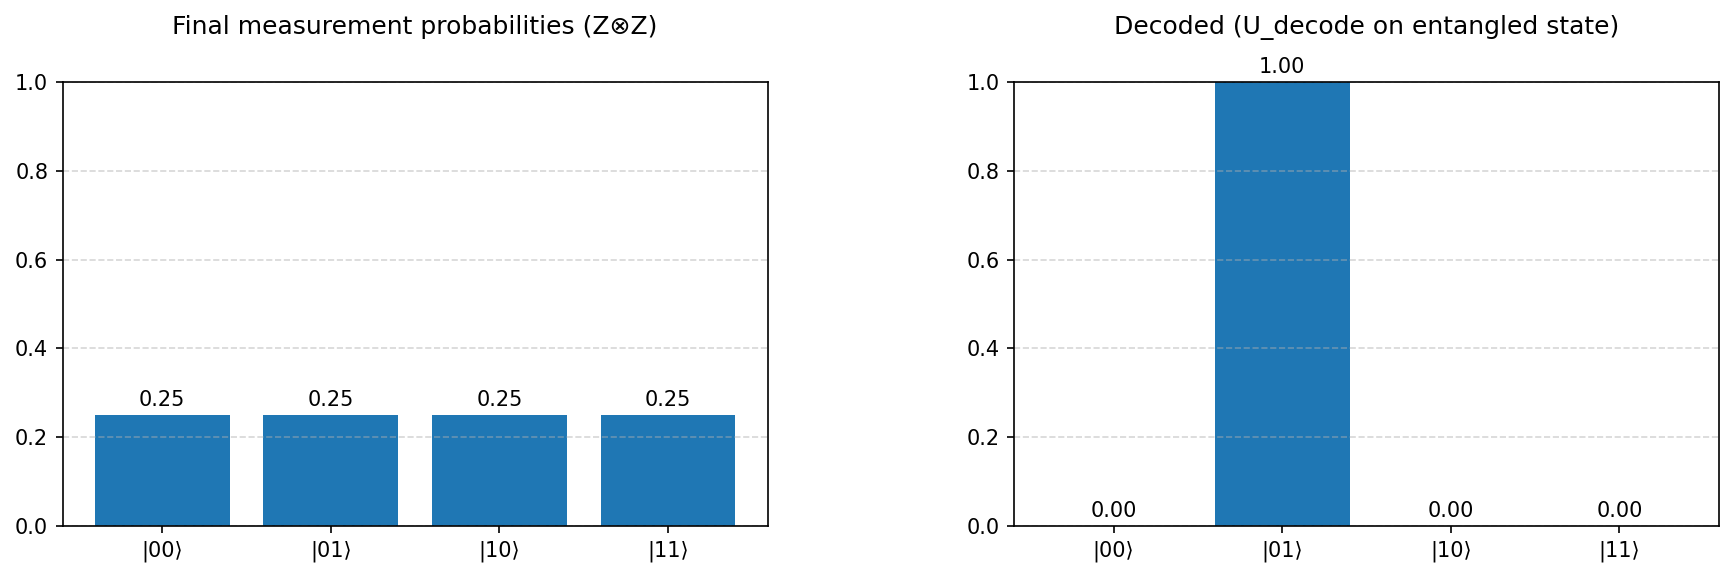

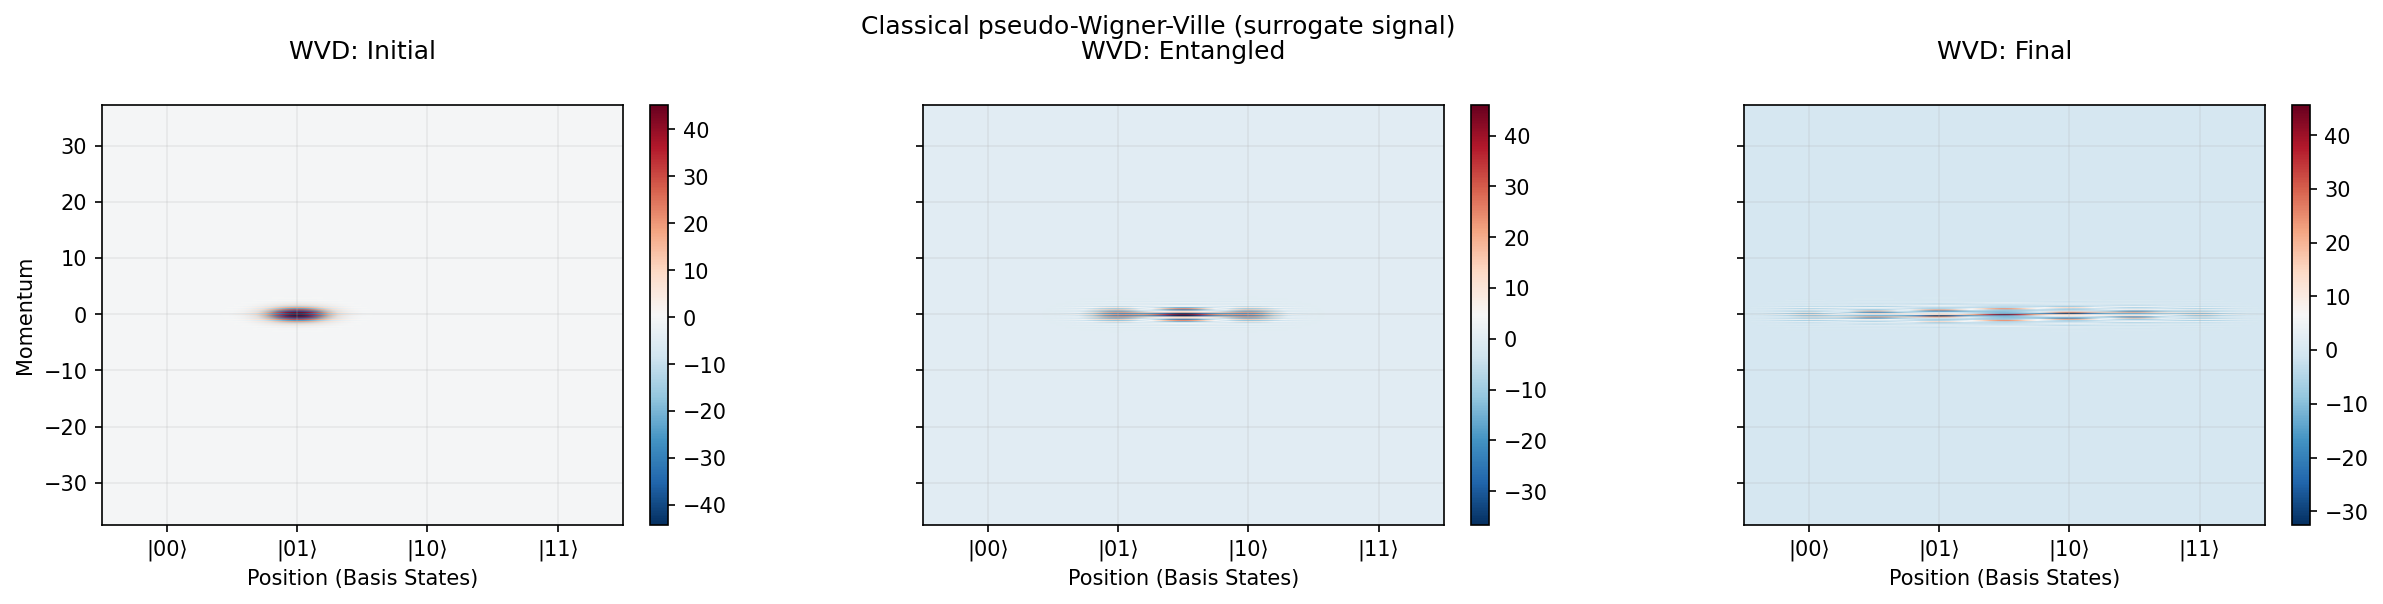

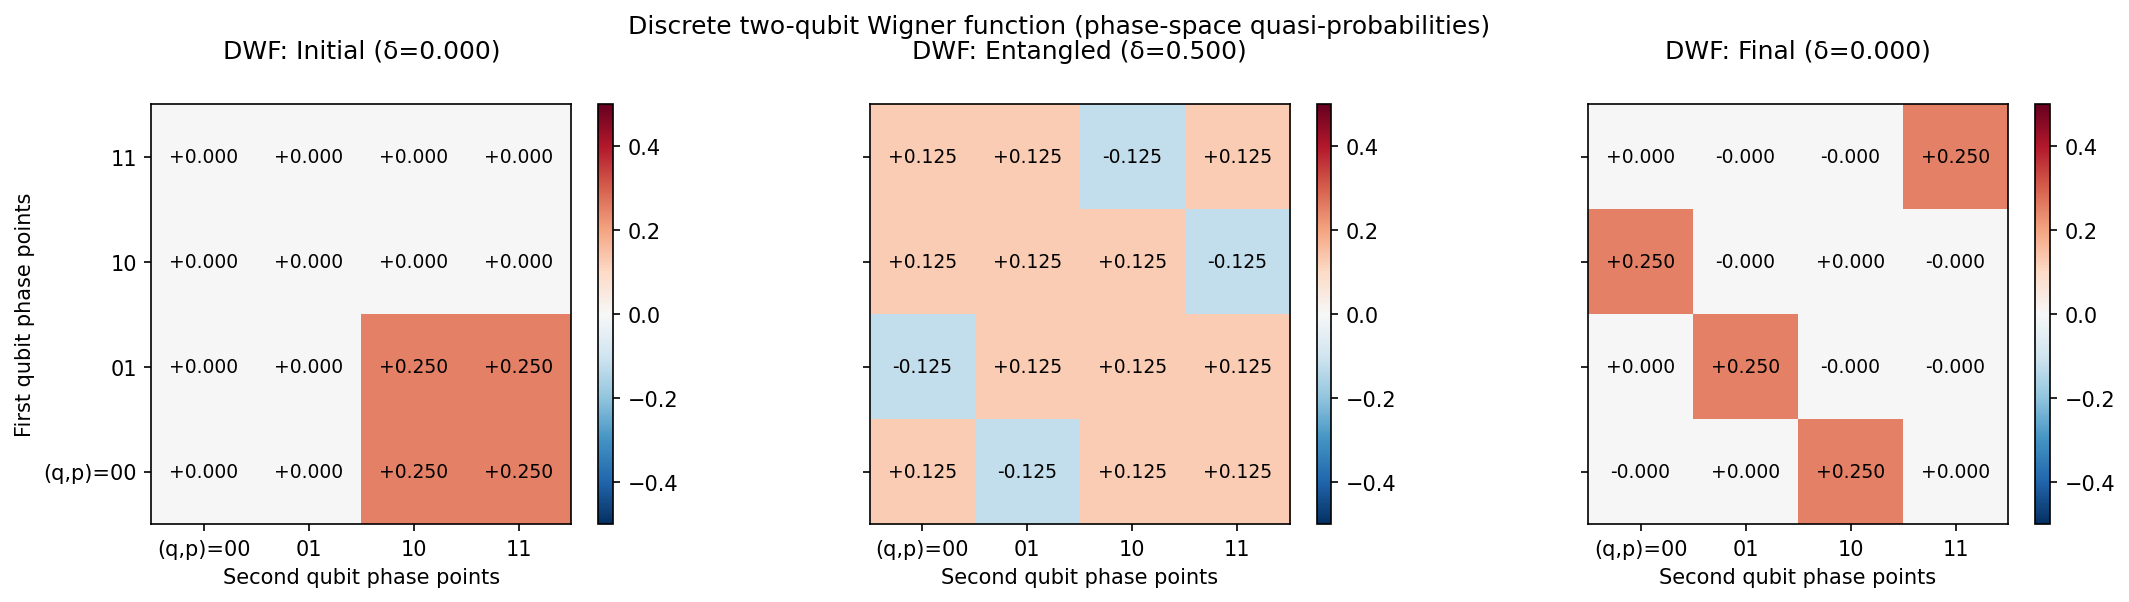

In [32]:
# -*- coding: utf-8 -*-
# two_qubit_tools.py (titles shifted upward)
# pylint: disable=invalid-name,too-many-arguments

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Tuple, List

import numpy as np
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

def dm(psi: np.ndarray) -> np.ndarray:
    psi = np.asarray(psi, dtype=np.complex128).reshape(-1)
    return np.outer(psi, np.conjugate(psi))

def tensor(*ops: np.ndarray) -> np.ndarray:
    out = np.array([[1.0+0.0j]])
    for op in ops:
        out = np.kron(out, op)
    return out

I2 = np.array([[1, 0], [0, 1]], dtype=np.complex128)
X  = np.array([[0, 1], [1, 0]], dtype=np.complex128)
Y  = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
Z  = np.array([[1, 0], [0, -1]], dtype=np.complex128)

basis_labels = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]

def ket(label: str) -> np.ndarray:
    mapping = {"00": 0, "01": 1, "10": 2, "11": 3}
    idx = mapping[label]
    v = np.zeros(4, dtype=np.complex128)
    v[idx] = 1.0 + 0.0j
    return v

H1 = (1.0/np.sqrt(2.0)) * np.array([[1, 1],[1,-1]], dtype=np.complex128)

def gate_H(qubit: int) -> np.ndarray:
    return tensor(H1, I2) if qubit == 0 else tensor(I2, H1)

def gate_Ry(theta: float, qubit: int) -> np.ndarray:
    c = np.cos(theta/2.0); s = np.sin(theta/2.0)
    Ry = np.array([[c,-s],[s,c]], dtype=np.complex128)
    return tensor(Ry, I2) if qubit == 0 else tensor(I2, Ry)

def gate_Rz(phi: float, qubit: int) -> np.ndarray:
    Rz = np.array([[np.exp(-1j*phi/2.0),0],[0,np.exp(1j*phi/2.0)]], dtype=np.complex128)
    return tensor(Rz, I2) if qubit == 0 else tensor(I2, Rz)

def gate_CNOT(control: int, target: int) -> np.ndarray:
    if control == target or control not in (0,1) or target not in (0,1):
        raise ValueError("control and target must be distinct qubits 0 or 1")
    if control == 0 and target == 1:
        return np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]], dtype=np.complex128)
    return np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]], dtype=np.complex128)

def exp_psi(psi: np.ndarray, op: np.ndarray) -> complex:
    return np.vdot(psi, op @ psi)

def pauli_correlators(psi: np.ndarray) -> Dict[str, float]:
    XX = tensor(X,X); YY = tensor(Y,Y); ZZ = tensor(Z,Z)
    return {
        "E_xx": float(np.real(exp_psi(psi, XX))),
        "E_yy": float(np.real(exp_psi(psi, YY))),
        "E_zz": float(np.real(exp_psi(psi, ZZ))),
    }

def fidelity_Psi_plus(psi: np.ndarray) -> float:
    c = pauli_correlators(psi)
    return float((1.0 + c["E_xx"] + c["E_yy"] - c["E_zz"]) / 4.0)

def bell_decoder_for_Hq0_CNOTq0to1() -> np.ndarray:
    return gate_H(0) @ gate_CNOT(0, 1)

def gaussian(x: np.ndarray, x0: float, sigma: float) -> np.ndarray:
    return np.exp(-0.5 * ((x - x0) / sigma) ** 2)

def state_to_signal(state: np.ndarray, x_coords: np.ndarray, positions: List[float], sigma: float) -> np.ndarray:
    signal = np.zeros_like(x_coords, dtype=np.complex128)
    for i, amp in enumerate(state.reshape(-1)):
        if np.abs(amp) > 0.0:
            signal += amp * gaussian(x_coords, positions[i], sigma)
    return signal

def wigner_ville_1d(signal: np.ndarray) -> np.ndarray:
    N = len(signal)
    pad = np.pad(signal, (N//2, N//2), mode="constant")
    wvd = np.zeros((N, N), dtype=np.complex128)
    m_range = np.arange(-N//2, N//2)
    for n in range(N):
        kernel = np.zeros(N, dtype=np.complex128)
        for m_idx, m in enumerate(m_range):
            i1 = n + N//2 + m; i2 = n + N//2 - m
            if 0 <= i1 < len(pad) and 0 <= i2 < len(pad):
                kernel[m_idx] = pad[i1] * np.conjugate(pad[i2])
        wvd[:, n] = fft(kernel)
    return fftshift(wvd, axes=0)

def phase_point_operator(q: int, p: int) -> np.ndarray:
    return 0.5 * (I2 + ((-1)**q)*Z + ((-1)**p)*X + ((-1)**(q+p))*Y)

def dwf_two_qubits(rho: np.ndarray) -> np.ndarray:
    rho = np.asarray(rho, dtype=np.complex128).reshape(4,4)
    pts = [(0,0),(0,1),(1,0),(1,1)]
    W = np.zeros((4,4), dtype=float)
    for i,(q1,p1) in enumerate(pts):
        A1 = phase_point_operator(q1,p1)
        for j,(q2,p2) in enumerate(pts):
            A2 = phase_point_operator(q2,p2)
            A = tensor(A1,A2)
            W[i,j] = float(np.real(np.trace(rho @ A) / 4.0))
    return W

def dwf_negativity(W: np.ndarray) -> float:
    return float((np.sum(np.abs(W)) - 1.0) / 2.0)

# ---------- Improved plotting (titles higher, more padding) ----------

def _append_cbar(fig: plt.Figure, ax: plt.Axes, im) -> None:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3.5%", pad=0.18)
    fig.colorbar(im, cax=cax)

def plot_wvd_row(fig: plt.Figure, xs: np.ndarray, ks: np.ndarray,
                 panels: List[Tuple[np.ndarray, str]],
                 basis_ticks: List[float], basis_ticklabels: List[str]) -> None:
    n = len(panels)
    # Increased wspace from 0.28 to 0.45 to add padding
    gs = fig.add_gridspec(nrows=1, ncols=n, left=0.06, right=0.98, top=0.88, bottom=0.18, wspace=0.45)
    axes = []
    for i, (wvd, title) in enumerate(panels):
        ax = fig.add_subplot(gs[0, i])
        im = ax.imshow(np.real(wvd), aspect="auto", cmap="RdBu_r", interpolation="bilinear",
                       extent=[xs[0], xs[-1], ks[0], ks[-1]], origin="lower")
        # Shifted title upward using the y-coordinate
        ax.set_title(title, y=1.08)
        ax.set_xlabel("Position (Basis States)")
        if i == 0:
            ax.set_ylabel("Momentum")
        else:
            ax.set_ylabel(None)
            ax.tick_params(axis="y", labelleft=False)
        ax.set_xticks(basis_ticks)
        ax.set_xticklabels(basis_ticklabels, rotation=0)
        ax.set_xlim(min(basis_ticks) - 3, max(basis_ticks) + 3)
        ax.set_ylim(ks[0] * 0.7, ks[-1] * 0.7)
        ax.grid(alpha=0.2)
        _append_cbar(fig, ax, im)
        axes.append(ax)
    fig.align_ylabels([axes[0]])

def plot_dwf_row(fig: plt.Figure, panels: List[Tuple[np.ndarray, str]]) -> None:
    pts_labels = ["(q,p)=00","01","10","11"]
    n = len(panels)
    # Increased wspace from 0.28 to 0.45 to add padding
    gs = fig.add_gridspec(nrows=1, ncols=n, left=0.06, right=0.98, top=0.88, bottom=0.18, wspace=0.45)
    axes = []
    for i, (W, title) in enumerate(panels):
        ax = fig.add_subplot(gs[0, i])
        im = ax.imshow(W, cmap="RdBu_r", interpolation="nearest", vmin=-0.5, vmax=0.5,
                       origin="lower", aspect="equal")
        # Shifted title upward using the y-coordinate
        ax.set_title(title, y=1.08)
        ax.set_xlabel("Second qubit phase points")
        if i == 0:
            ax.set_ylabel("First qubit phase points")
        else:
            ax.set_ylabel(None)
            ax.tick_params(axis="y", labelleft=False)
        ax.set_xticks(range(4)); ax.set_xticklabels(pts_labels)
        ax.set_yticks(range(4)); ax.set_yticklabels(pts_labels)
        for r in range(4):
            for c in range(4):
                ax.text(c, r, f"{W[r,c]:+.3f}", ha="center", va="center", fontsize=9)
        _append_cbar(fig, ax, im)
        axes.append(ax)
    fig.align_ylabels([axes[0]])

@dataclass
class SimConfig:
    init_label: str = "01"
    hadamard_on: int = 0
    cnot_control: int = 0
    cnot_target: int = 1
    theta_y: float = np.pi / 4
    phi_z: float = np.pi / 2
    N: int = 512
    x_min: float = -15.0
    x_max: float = 15.0
    basis_positions: Tuple[float, float, float, float] = (-9.0, -3.0, 3.0, 9.0)
    gauss_sigma: float = 1.5
    apply_decoder_on_entangled: bool = True
    apply_decoder_on_final: bool = False

def run_demo(cfg: SimConfig) -> Dict[str, np.ndarray]:
    psi0 = ket(cfg.init_label)
    Hq = gate_H(cfg.hadamard_on); C = gate_CNOT(cfg.cnot_control, cfg.cnot_target)
    psi_after_H = Hq @ psi0; psi_ent = C @ psi_after_H

    Ry0 = gate_Ry(cfg.theta_y, 0); Ry1 = gate_Ry(cfg.theta_y, 1)
    Rz0 = gate_Rz(cfg.phi_z, 0);   Rz1 = gate_Rz(cfg.phi_z, 1)
    U_rot_both = Rz0 @ Rz1 @ Ry0 @ Ry1
    psi_final = U_rot_both @ psi_ent

    U_dec = bell_decoder_for_Hq0_CNOTq0to1()
    psi_dec_ent = U_dec @ psi_ent if cfg.apply_decoder_on_entangled else None
    psi_dec_final = U_dec @ psi_final if cfg.apply_decoder_on_final else None

    def probs(psi: np.ndarray) -> np.ndarray:
        if psi is None: return None
        p = np.abs(psi.reshape(-1)) ** 2
        return p / np.sum(p)

    p_final = probs(psi_final); p_dec_ent = probs(psi_dec_ent); p_dec_final = probs(psi_dec_final)

    cors_ent = pauli_correlators(psi_ent); cors_fin = pauli_correlators(psi_final)
    F_ent = fidelity_Psi_plus(psi_ent);     F_fin = fidelity_Psi_plus(psi_final)

    rho0 = dm(psi0); rho_ent = dm(psi_ent); rho_fin = dm(psi_final)
    W0 = dwf_two_qubits(rho0); Went = dwf_two_qubits(rho_ent); Wfin = dwf_two_qubits(rho_fin)

    x = np.linspace(cfg.x_min, cfg.x_max, cfg.N)
    dx = x[1] - x[0]; k = fftshift(np.fft.fftfreq(cfg.N, dx)) * 2.0 * np.pi
    basis_ticks = list(cfg.basis_positions)
    signal0 = state_to_signal(psi0, x, basis_ticks, cfg.gauss_sigma)
    signal_ent = state_to_signal(psi_ent, x, basis_ticks, cfg.gauss_sigma)
    signal_fin = state_to_signal(psi_final, x, basis_ticks, cfg.gauss_sigma)
    WVD0 = wigner_ville_1d(signal0); WVDent = wigner_ville_1d(signal_ent); WVDfin = wigner_ville_1d(signal_fin)

    return {
        "psi0": psi0, "psi_after_H": psi_after_H, "psi_ent": psi_ent, "psi_final": psi_final,
        "psi_dec_ent": psi_dec_ent, "psi_dec_final": psi_dec_final,
        "p_final": p_final, "p_dec_ent": p_dec_ent, "p_dec_final": p_dec_final,
        "cors_ent": cors_ent, "cors_fin": cors_fin, "F_ent": F_ent, "F_fin": F_fin,
        "W0": W0, "Went": Went, "Wfin": Wfin,
        "WVD0": WVD0, "WVDent": WVDent, "WVDfin": WVDfin,
        "x": x, "k": k, "basis_ticks": basis_ticks, "basis_ticklabels": basis_labels,
    }

def summarize_results(res: Dict[str, np.ndarray]) -> None:
    # Use a try-except block to handle display in different environments
    try:
        from IPython.display import display
        can_display = True
    except ImportError:
        can_display = False

    df = pd.DataFrame([
        {"State": "Entangled (after CNOT)", **res["cors_ent"], "F_PsiPlus": res["F_ent"]},
        {"State": "Final (after rotations)", **res["cors_fin"], "F_PsiPlus": res["F_fin"]},
    ])
    pd.set_option("display.precision", 6)
    print("Pauli correlators and Ψ+ fidelity estimate:")
    if can_display:
        display(df)
    else:
        print(df)

    # Probabilities panels
    labels = res["basis_ticklabels"]
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.bar(labels, res["p_final"])
    ax1.set_ylim(0, 1)
    # Shifted title upward using the y-coordinate
    ax1.set_title("Final measurement probabilities (Z⊗Z)", y=1.08)
    for i, p in enumerate(res["p_final"]):
        ax1.text(i, p + 0.02, f"{p:.2f}", ha="center")
    ax1.grid(axis="y", linestyle="--", alpha=0.5)

    ax2 = fig.add_subplot(1, 2, 2)
    if res["p_dec_ent"] is not None:
        ax2.bar(labels, res["p_dec_ent"])
        # Shifted title upward using the y-coordinate
        ax2.set_title("Decoded (U_decode on entangled state)", y=1.08)
        for i, p in enumerate(res["p_dec_ent"]):
            ax2.text(i, p + 0.02, f"{p:.2f}", ha="center")
    elif res["p_dec_final"] is not None:
        ax2.bar(labels, res["p_dec_final"])
        # Shifted title upward using the y-coordinate
        ax2.set_title("Decoded (U_decode on final state)", y=1.08)
        for i, p in enumerate(res["p_dec_final"]):
            ax2.text(i, p + 0.02, f"{p:.2f}", ha="center")
    else:
        ax2.axis("off")
        # Shifted title upward using the y-coordinate
        ax2.set_title("Decoder disabled", y=1.08)
    ax2.set_ylim(0, 1)
    ax2.grid(axis="y", linestyle="--", alpha=0.5)
    # Increased wspace for more padding between subplots
    fig.subplots_adjust(left=0.06, right=0.98, top=0.90, bottom=0.16, wspace=0.35)
    plt.show()

    # WVD row
    fig = plt.figure(figsize=(16, 4))
    plot_wvd_row(fig, res["x"], res["k"],
                 [(res["WVD0"], "WVD: Initial"),
                  (res["WVDent"], "WVD: Entangled"),
                  (res["WVDfin"], "WVD: Final")],
                 res["basis_ticks"], res["basis_ticklabels"])
    # Shifted suptitle upward
    fig.suptitle("Classical pseudo-Wigner-Ville (surrogate signal)", y=1.03)
    plt.show()

    # DWF row
    fig = plt.figure(figsize=(14, 4))
    plot_dwf_row(fig, [
        (res["W0"],  f"DWF: Initial (δ={dwf_negativity(res['W0']):.3f})"),
        (res["Went"], f"DWF: Entangled (δ={dwf_negativity(res['Went']):.3f})"),
        (res["Wfin"], f"DWF: Final (δ={dwf_negativity(res['Wfin']):.3f})"),
    ])
    # Shifted suptitle upward
    fig.suptitle("Discrete two-qubit Wigner function (phase-space quasi-probabilities)", y=1.03)
    plt.show()


if __name__ == "__main__":
    # This block allows the script to be run directly to generate plots.
    plt.rcParams["figure.dpi"] = 150
    plt.rcParams["figure.facecolor"] = "white"

    # Configure the simulation
    simulation_config = SimConfig(
        init_label="01",
        hadamard_on=0,
        cnot_control=0,
        cnot_target=1,
        theta_y=np.pi / 4,
        phi_z=np.pi / 2,
        gauss_sigma=1.5,
        apply_decoder_on_entangled=True,
        apply_decoder_on_final=False,
    )

    # Run the simulation and get the results
    results = run_demo(simulation_config)

    # Generate and display the plots and summary
    summarize_results(results)

Pauli correlators and Ψ+ fidelity estimate:


,State,E_xx,E_yy,E_zz,F_PsiPlus
0,Entangled (after CNOT),0.000000e+00,0.0,0.0,0.25
1,Final (after rotations),5.551115e-17,-0.5,0.5,0.00


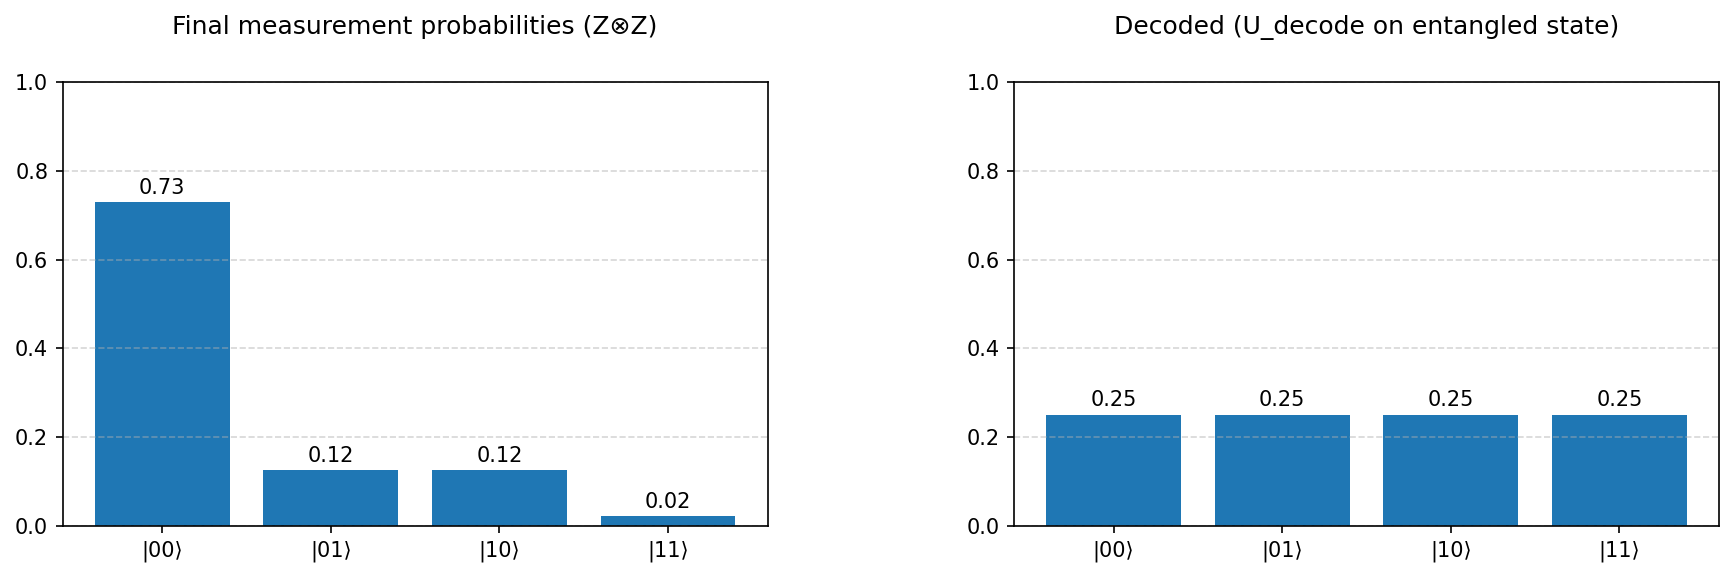

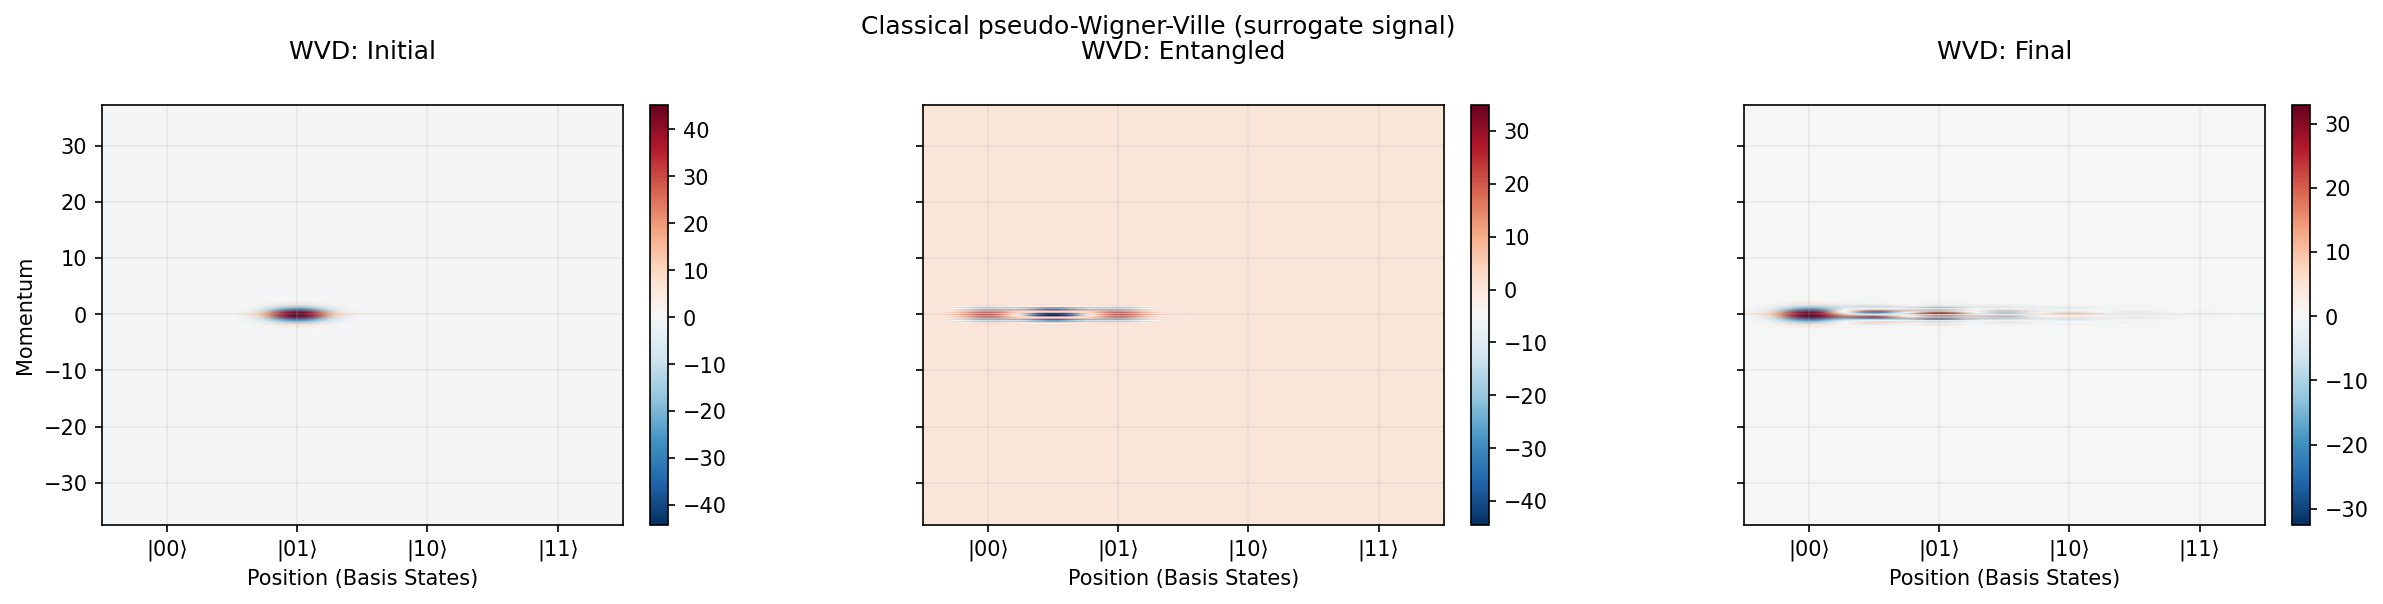

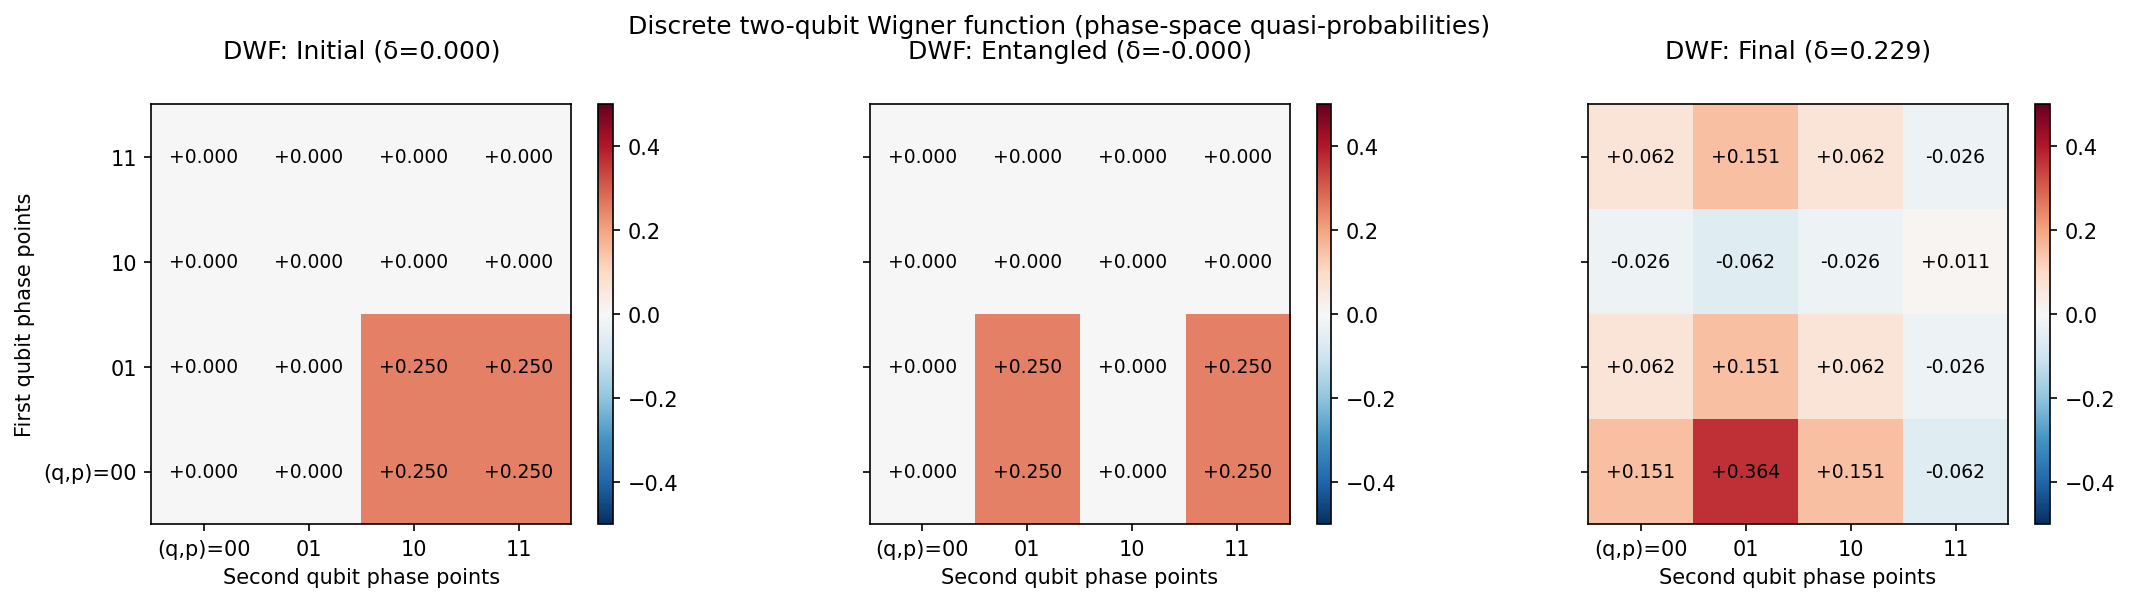

In [33]:
#@title Verify the H target (apply H on q1 instead) and re-run
cfg_q1 = SimConfig(
    init_label="01",
    hadamard_on=1, cnot_control=0, cnot_target=1,   # H on q1 now
    theta_y=np.pi/4, phi_z=np.pi/2,
    gauss_sigma=1.5,
    apply_decoder_on_entangled=True,
    apply_decoder_on_final=False
)

res_q1 = run_demo(cfg_q1)
summarize_results(res_q1)

In [34]:
# @title A) Imports & reproducibility
import numpy as np
import pandas as pd

from numpy.linalg import norm
from two_qubit_tools import (
    X, Y, Z, I2, tensor, dm,
    gate_H, gate_CNOT, gate_Ry, gate_Rz,
    pauli_correlators, fidelity_Psi_plus,
    dwf_two_qubits, dwf_negativity,
    ket, SimConfig, run_demo
)

np.set_printoptions(precision=6, suppress=True)
pd.set_option("display.precision", 6)
print("Loaded two_qubit_tools and numpy/pandas.")

Loaded two_qubit_tools and numpy/pandas.


In [35]:
# @title B) Rebuild |Ψ+⟩ and verify Pauli correlators + projector identity
# Build |Ψ+> from |01> using H(q0) then CNOT(q0->q1)
psi0 = ket("01")
U_encode = gate_CNOT(0, 1) @ gate_H(0)   # rightmost acts first on kets
psi_ent = U_encode @ psi0                # should be |Ψ+> = (|01> + |10>)/sqrt(2)

# (1) Pauli correlators and fidelity witness
cors = pauli_correlators(psi_ent)
F_psiplus = fidelity_Psi_plus(psi_ent)

print("Pauli correlators for |Ψ+⟩:")
print(pd.Series(cors))
print(f"\nFidelity witness F_{'{'}Ψ+{'}'} = {F_psiplus:.6f} (expect 1.0)")

# (2) Projector identity  |Ψ+><Ψ+| = 1/4(I⊗I + X⊗X + Y⊗Y − Z⊗Z)
rho_ent = dm(psi_ent)
P_from_paulis = 0.25 * (
    np.kron(I2, I2) + np.kron(X, X) + np.kron(Y, Y) - np.kron(Z, Z)
)
proj_err = norm(rho_ent - P_from_paulis, ord='fro')

print(f"\n‖ |Ψ+⟩⟨Ψ+| − (I⊗I + X⊗X + Y⊗Y − Z⊗Z)/4 ‖_F = {proj_err:.3e} (expect ~0)")

Pauli correlators for |Ψ+⟩:
E_xx    1.0
E_yy    1.0
E_zz   -1.0
dtype: float64

Fidelity witness F_{Ψ+} = 1.000000 (expect 1.0)

‖ |Ψ+⟩⟨Ψ+| − (I⊗I + X⊗X + Y⊗Y − Z⊗Z)/4 ‖_F = 2.220e-16 (expect ~0)


In [36]:
# @title C) Verify the Bell decoder is the inverse (adjoint) of the encoder
U_decode = gate_H(0) @ gate_CNOT(0, 1)   # (CNOT·H)† = H·CNOT
Id_ideal   = np.eye(4, dtype=np.complex128)
Id_check   = U_decode @ U_encode
inv_err    = norm(Id_check - Id_ideal, ord='fro')

# Check action on the entangled state: decode(|Ψ+>) → |01>
psi_decoded = U_decode @ psi_ent
prob_decoded = np.abs(psi_decoded.ravel())**2

print(f"‖ U_decode · U_encode − I ‖_F = {inv_err:.3e} (expect ~0)")
print("\nDecoder measurement probabilities in {|00>,|01>,|10>,|11>}:")
print(pd.Series(prob_decoded, index=["|00⟩","|01⟩","|10⟩","|11⟩"]))

‖ U_decode · U_encode − I ‖_F = 4.463e-16 (expect ~0)

Decoder measurement probabilities in {|00>,|01>,|10>,|11>}:
|00⟩    0.0
|01⟩    1.0
|10⟩    0.0
|11⟩    0.0
dtype: float64


In [37]:
# @title D) Two-qubit discrete Wigner (4×4) for Bell and for the rotated “final” state
# Discrete Wigner for the Bell state
W_bell = dwf_two_qubits(rho_ent)
neg_bell = dwf_negativity(W_bell)
sum_bell = float(W_bell.sum())

# Build your "final" state using the same parameters as your figures:
cfg = SimConfig(
    init_label="01",
    hadamard_on=0, cnot_control=0, cnot_target=1,
    theta_y=np.pi/4, phi_z=np.pi/2,
    gauss_sigma=1.5,
    apply_decoder_on_entangled=True,  # as in your plots
    apply_decoder_on_final=False
)
res = run_demo(cfg)
rho_final = dm(res["psi_final"])
W_final = dwf_two_qubits(rho_final)
neg_final = dwf_negativity(W_final)
sum_final = float(W_final.sum())

def dwf_dataframe(W):
    # rows/cols indexed by (q,p) in order 00,01,10,11
    labels = ["(q,p)=00","01","10","11"]
    return pd.DataFrame(W, index=labels, columns=labels)

print("Discrete Wigner — |Ψ+⟩ (Bell):  sum =", f"{sum_bell:.6f}", "  δ =", f"{neg_bell:.6f}")
display(dwf_dataframe(W_bell))

print("\nDiscrete Wigner — final rotated state:  sum =", f"{sum_final:.6f}", "  δ =", f"{neg_final:.6f}")
display(dwf_dataframe(W_final))

Discrete Wigner — |Ψ+⟩ (Bell):  sum = 1.000000   δ = 0.500000


,"(q,p)=00",01,10,11
"(q,p)=00",0.125,-0.125,0.125,0.125
01,-0.125,0.125,0.125,0.125
10,0.125,0.125,0.125,-0.125
11,0.125,0.125,-0.125,0.125



Discrete Wigner — final rotated state:  sum = 1.000000   δ = 0.000000


,"(q,p)=00",01,10,11
"(q,p)=00",-5.551115e-17,1.387779e-17,2.500000e-01,1.387779e-17
01,3.469447e-17,2.500000e-01,-2.081668e-17,-6.938894e-18
10,2.500000e-01,-2.081668e-17,5.551115e-17,-2.081668e-17
11,6.938894e-18,-6.938894e-18,-2.775558e-17,2.500000e-01


In [38]:
# @title E) Sanity checks: normalization & simple invariances
def sanity_checks(W, name):
    # (i) normalization
    s = float(W.sum())
    # (ii) bounds: entries should sum to 1 but can be negative individually
    wmin, wmax = float(W.min()), float(W.max())
    print(f"{name}: sum={s:.6f}, min={wmin:.6f}, max={wmax:.6f}")

sanity_checks(W_bell,  "DWF(|Ψ+⟩)")
sanity_checks(W_final, "DWF(final)")

# Optional: check that correlators of |Ψ+> match (+1,+1,−1)
print("\nCorrelators recap for |Ψ+⟩ (expect +1, +1, −1):")
print(pd.Series(cors))

DWF(|Ψ+⟩): sum=1.000000, min=-0.125000, max=0.125000
DWF(final): sum=1.000000, min=-0.000000, max=0.250000

Correlators recap for |Ψ+⟩ (expect +1, +1, −1):
E_xx    1.0
E_yy    1.0
E_zz   -1.0
dtype: float64
